**Table of contents**<a id='toc0_'></a>    
- [Building Energy Use Intensity (EUI) Prediction Model](#toc1_)    
  - [Objective](#toc1_1_)    
  - [Dataset](#toc1_2_)    
  - [Key Variable Definitions](#toc1_3_)    
  - [Setup and Data Loading](#toc1_4_)    
  - [Data Preprocessing](#toc1_5_)    
    - [Handling Missing Values](#toc1_5_1_)    
    - [Feature Selection](#toc1_5_2_)    
    - [Train-Test Split and Yearbuilt Imputation](#toc1_5_3_)    
    - [Preprocessing Pipeline](#toc1_5_4_)    
  - [Model Training](#toc1_6_)    
    - [Linear Regression (Baseline)](#toc1_6_1_)    
    - [Random Forest with Hyperparameter Tuning](#toc1_6_2_)    
    - [SHAP Analysis Interpretation](#toc1_6_3_)    
    - [LightGBM with Hyperparameter Tuning](#toc1_6_4_)    
    - [Model Comparison](#toc1_6_5_)    
  - [Feature Importance Analysis](#toc1_7_)    
    - [Understanding the Feature Importance Charts](#toc1_7_1_)    
  - [Residual Analysis](#toc1_8_)    
  - [Savings Potential Analysis](#toc1_9_)    
    - [Savings Potential by Building Type](#toc1_9_1_)    
    - [Savings Potential by Meter Type](#toc1_9_2_)    
    - [Savings Potential by Region](#toc1_9_3_)    
    - [Top 10 Priority Buildings for Retrofit](#toc1_9_4_)    
    - [Summary Statistics](#toc1_9_5_)    
  - [Model Validation and Robustness Checks](#toc1_10_)    
    - [Group-Based Split by Site ID](#toc1_10_1_)    
    - [Temporal Split: Train on 2016, Test on 2017](#toc1_10_2_)    
    - [Validation Summary](#toc1_10_3_)    
    - [Additional Exploratory Tests](#toc1_10_4_)    
  - [Conclusions](#toc1_11_)    
    - [Summary of Findings](#toc1_11_1_)    
    - [Actionable Recommendations](#toc1_11_2_)    
    - [Limitations](#toc1_11_3_)    
    - [Future Work](#toc1_11_4_)    
  - [Save Figures for Report](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Building Energy Use Intensity (EUI) Prediction Model](#toc0_)

## <a id='toc1_1_'></a>[Objective](#toc0_)

This notebook develops a predictive model for building Energy Use Intensity (EUI) using the BDG2 dataset. The model identifies energy-inefficient buildings by comparing actual (log) EUI to predicted values based on building characteristics. Buildings that consume significantly more energy than predicted represent priority targets for energy audits and retrofits.

## <a id='toc1_2_'></a>[Dataset](#toc0_)

The Building Data Genome 2 (BDG2) dataset contains hourly meter readings from 1,636 non-residential buildings across North America and Europe, spanning 2016-2017. This analysis uses annualized EUI values aggregated by building and meter type.

## <a id='toc1_3_'></a>[Key Variable Definitions](#toc0_)

| Variable | Type | Description |
|----------|------|-------------|
| **Target Variable** | | |
| `log_eui` | Numerical | Log-transformed Energy Use Intensity (kWh/sqm); target variable for prediction |
| **Categorical Features** | | |
| `primaryspaceusage` | Categorical | Primary building use category (EnergyStar classification): Education, Office, Lodging, Healthcare, etc. |
| `region` | Categorical | Geographic region where the building is located |
| `meter` | Categorical | Energy meter type: electricity, gas, chilledwater, hotwater, steam, water, irrigation, solar |
| **Numerical Features** | | |
| `yearbuilt` | Numerical | Year of construction (YYYY format) |
| `Avg_AirTemp_Annual` | Numerical | Annual average air temperature at building location (°C) |
| **Identifiers (not used as features)** | | |
| `building_id` | Identifier | Building identifier with structure SiteID_SimplifiedUsage_UniqueName |
| `site_id` | Identifier | Animal-code-name for the site/campus; used for imputation but excluded from model |
| `year` | Identifier | Year of measurement (2016 or 2017); used for temporal split validation |

---

This notebook presents a complete workflow for:

1. **Data preparation** with proper handling of missing values and train-test splitting
2. **Model development** comparing Linear Regression, Random Forest, and LightGBM
3. **Feature importance analysis** identifying meter type and building usage as key drivers
4. **Savings potential quantification** by building type, meter type, and region
5. **Robustness validation** using multiple splitting strategies
6. **Actionable recommendations** for targeting energy efficiency improvements

The model successfully identifies underperforming buildings and quantifies savings potential, providing a foundation for data-driven energy efficiency programs.

---
## <a id='toc1_4_'></a>[Setup and Data Loading](#toc0_)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import randint, uniform

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the prepared analysis dataset
path = "../data/"
df = pd.read_csv(path + "df_analysis.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (5902, 11)

Columns: ['Avg_AirTemp_Annual', 'year', 'meter', 'site_id', 'region', 'country', 'yearbuilt', 'primaryspaceusage', 'total_meter_reading', 'eui', 'log_eui']


,Avg_AirTemp_Annual,year,meter,site_id,region,country,yearbuilt,primaryspaceusage,total_meter_reading,eui,log_eui
0,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,1933.0,Entertainment/public assembly,3.020396e+06,136.564438,4.924092
1,14.965894,2017,electricity,Bear,"Berkeley, California",United States of America,1933.0,Entertainment/public assembly,4.115350e+06,186.071809,5.231493
2,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,1958.0,Entertainment/public assembly,3.868207e+05,138.051652,4.934845
3,14.965894,2017,electricity,Bear,"Berkeley, California",United States of America,1958.0,Entertainment/public assembly,3.652301e+05,130.346201,4.877837
4,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,2016.0,Entertainment/public assembly,5.612824e+05,73.080796,4.305156


In [3]:
# Examine data types and missing values
print("Data types and non-null counts:")
print(df.info())

print("\nMissing values (percentage):")
missing_pct = (df.isnull().sum() / len(df)) * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Avg_AirTemp_Annual   5902 non-null   float64
 1   year                 5902 non-null   int64  
 2   meter                5902 non-null   object 
 3   site_id              5902 non-null   object 
 4   region               4897 non-null   object 
 5   country              4897 non-null   object 
 6   yearbuilt            2781 non-null   float64
 7   primaryspaceusage    5847 non-null   object 
 8   total_meter_reading  5902 non-null   float64
 9   eui                  5902 non-null   float64
 10  log_eui              5902 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 507.3+ KB
None

Missing values (percentage):
yearbuilt            52.880380
region               17.028126
country              17.028126
primaryspaceusage  

---
## <a id='toc1_5_'></a>[Data Preprocessing](#toc0_)

### <a id='toc1_5_1_'></a>[Handling Missing Values](#toc0_)

The preprocessing strategy addresses missing values while preventing data leakage:

| Variable | Issue | Solution | When Applied |
|----------|-------|----------|-------------|
| `region` | ~3% missing | Impute using temperature matching (assign to region with closest median annual temperature) | Before split (geographic attribute, uses only features) |
| `primaryspaceusage` | ~1% missing | Drop rows (critical categorical feature) | Before split |
| `yearbuilt` | ~15% missing | Group-wise median imputation by `site_id` | After split (learned statistic) |

In [4]:
# Impute missing region values using temperature matching
# Buildings are assigned to the region with the closest median annual temperature

region_temps = df.groupby('region')['Avg_AirTemp_Annual'].median()

def assign_region_by_temp(row):
    if pd.isna(row['region']) and pd.notna(row['Avg_AirTemp_Annual']):
        return (region_temps - row['Avg_AirTemp_Annual']).abs().idxmin()
    return row['region']

df['region'] = df.apply(assign_region_by_temp, axis=1)

print(f"Region missing values after imputation: {df['region'].isna().sum()}")

Region missing values after imputation: 0


In [5]:
# Drop rows with missing primaryspaceusage (~1% of data)
rows_before = len(df)
df = df.dropna(subset=['primaryspaceusage'])
print(f"Rows dropped due to missing primaryspaceusage: {rows_before - len(df)}")

# Remove exact duplicates
duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Exact duplicates removed: {duplicates}")
print(f"Final dataset size: {len(df)} rows")

Rows dropped due to missing primaryspaceusage: 55
Exact duplicates removed: 17
Final dataset size: 5830 rows


### <a id='toc1_5_2_'></a>[Feature Selection](#toc0_)

The model uses the following features to predict log-transformed EUI:

- **Categorical features:** `primaryspaceusage`, `region`, `meter`
- **Numerical features:** `yearbuilt`, `Avg_AirTemp_Annual`

Note: `site_id` is used for imputation purposes but excluded as a model feature. Testing showed that including `site_id` provides no predictive benefit while reducing model generalizability.

In [6]:
# Define feature sets and target variable
cat_features = ['primaryspaceusage', 'region', 'meter']
num_features = ['yearbuilt', 'Avg_AirTemp_Annual']
target = 'log_eui'

print(f"Categorical features: {cat_features}")
print(f"Numerical features: {num_features}")
print(f"Target variable: {target}")

Categorical features: ['primaryspaceusage', 'region', 'meter']
Numerical features: ['yearbuilt', 'Avg_AirTemp_Annual']
Target variable: log_eui


### <a id='toc1_5_3_'></a>[Train-Test Split and Yearbuilt Imputation](#toc0_)

The `GroupMedianImputer` fills missing `yearbuilt` values using a two-tier strategy:

1. **Group median:** Fill with the median year built of other buildings at the same `site_id` (buildings on the same campus are likely built around the same time)
2. **Global fallback:** If a site has no known `yearbuilt` values, use the overall median from the training data

This imputation is performed after the train-test split to prevent data leakage.

In [7]:
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    """Impute a numeric column using the median per-group calculated from training data."""
    
    def __init__(self, group_col, value_col, imputed_col=None):
        self.group_col = group_col
        self.value_col = value_col
        self.imputed_col = imputed_col or f"{value_col}_imputed"

    def fit(self, X, y=None):
        df = X if hasattr(X, 'copy') else pd.DataFrame(X)
        self.group_medians_ = df.groupby(self.group_col)[self.value_col].median().to_dict()
        self.global_median_ = df[self.value_col].dropna().median() if df[self.value_col].dropna().size > 0 else pd.NA
        return self

    def transform(self, X):
        df = X.copy()
        df[self.imputed_col] = df[self.value_col].isna()
        df['_group_med'] = df[self.group_col].map(self.group_medians_)
        df[self.value_col] = df[self.value_col].fillna(df['_group_med']).fillna(self.global_median_)
        if not pd.isna(self.global_median_):
            df[self.value_col] = df[self.value_col].round().astype('Int64')
        df = df.drop(columns=['_group_med'])
        return df

In [8]:
# Perform train-test split (80/20)
cols_for_split = cat_features + num_features + ['site_id']

train_df, test_df = train_test_split(df[cols_for_split], test_size=0.2, random_state=42)
y_train, y_test = train_test_split(df[target], test_size=0.2, random_state=42)

print(f"Training set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

# Apply group-wise imputation for yearbuilt
group_imputer = GroupMedianImputer(group_col='site_id', value_col='yearbuilt', imputed_col='yearbuilt_imputed')
train_imputed = group_imputer.fit_transform(train_df)
test_imputed = group_imputer.transform(test_df)

print(f"\nGlobal median yearbuilt (from training): {group_imputer.global_median_}")
print(f"Total rows with imputed yearbuilt: {train_imputed['yearbuilt_imputed'].sum() + test_imputed['yearbuilt_imputed'].sum()}")

Training set: 4664 rows
Test set: 1166 rows

Global median yearbuilt (from training): 1975.0
Total rows with imputed yearbuilt: 3109


In [9]:
# Prepare feature matrices
X_train = train_imputed[cat_features + num_features]
X_test = test_imputed[cat_features + num_features]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
X_train.head()

X_train shape: (4664, 5)
X_test shape: (1166, 5)


,primaryspaceusage,region,meter,yearbuilt,Avg_AirTemp_Annual
4779,Retail,"Orlando, Florida",gas,1996,22.828962
3060,Education,"Minneapolis, Minnesota",chilledwater,1975,9.878778
1732,Education,"City of Westminster, England",chilledwater,1975,13.267862
3344,Office,"Minneapolis, Minnesota",electricity,1975,9.878778
253,Education,"Greater London, England",hotwater,1975,11.485664


### <a id='toc1_5_4_'></a>[Preprocessing Pipeline](#toc0_)

The preprocessing pipeline applies:
- **StandardScaler** to numerical features (zero mean, unit variance)
- **OneHotEncoder** to categorical features (creates binary indicator columns)

In [10]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

print("Preprocessing pipeline created.")
print(f"  - Numerical features ({len(num_features)}): StandardScaler")
print(f"  - Categorical features ({len(cat_features)}): OneHotEncoder")

Preprocessing pipeline created.
  - Numerical features (2): StandardScaler
  - Categorical features (3): OneHotEncoder


---
The data has been loaded, cleaned, and prepared for modeling. The train-test split ensures no data leakage in the `yearbuilt` imputation process.

---
## <a id='toc1_6_'></a>[Model Training](#toc0_)

### <a id='toc1_6_1_'></a>[Linear Regression (Baseline)](#toc0_)

Linear Regression serves as the baseline model. It assumes a linear relationship between features and the target variable, providing a reference point for evaluating more complex models.

In [11]:
# Train Linear Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)

# Evaluate on train and test sets
y_pred_lr_train = pipeline_lr.predict(X_train)
y_pred_lr_test = pipeline_lr.predict(X_test)

mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
r2_lr_train = r2_score(y_train, y_pred_lr_train)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

print("--- Linear Regression Results ---")
print(f"Train MSE: {mse_lr_train:.4f}, Train R²: {r2_lr_train:.4f}")
print(f"Test MSE:  {mse_lr_test:.4f}, Test R²:  {r2_lr_test:.4f}")

--- Linear Regression Results ---
Train MSE: 2.7806, Train R²: 0.4282
Test MSE:  3.0936, Test R²:  0.4372


### <a id='toc1_6_2_'></a>[Random Forest with Hyperparameter Tuning](#toc0_)

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. Hyperparameter tuning via `RandomizedSearchCV` with 5-fold cross-validation identifies optimal settings for:

- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum depth of each tree
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required at a leaf node
- `max_features`: Number of features to consider at each split

In [12]:
# Define hyperparameter search space
param_distributions = {
    'regressor__n_estimators': randint(50, 300),
    'regressor__max_depth': [10, 20, 30, 50, None],
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

# Create pipeline for tuning
pipeline_rf_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Perform randomized search with 5-fold cross-validation
print("Starting Random Forest hyperparameter tuning...")
random_search = RandomizedSearchCV(
    pipeline_rf_tuning,
    param_distributions,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"\nBest cross-validation R²: {random_search.best_score_:.4f}")
print(f"\nBest hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best cross-validation R²: 0.6769

Best hyperparameters:
  regressor__max_depth: None
  regressor__max_features: None
  regressor__min_samples_leaf: 1
  regressor__min_samples_split: 8
  regressor__n_estimators: 58


In [13]:
# Evaluate the tuned Random Forest model
best_rf_model = random_search.best_estimator_

y_pred_rf_train = best_rf_model.predict(X_train)
y_pred_rf_test = best_rf_model.predict(X_test)

mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print("--- Tuned Random Forest Results ---")
print(f"Train MSE: {mse_rf_train:.4f}, Train R²: {r2_rf_train:.4f}")
print(f"Test MSE:  {mse_rf_test:.4f}, Test R²:  {r2_rf_test:.4f}")

--- Tuned Random Forest Results ---
Train MSE: 0.9363, Train R²: 0.8075
Test MSE:  1.6379, Test R²:  0.7020


In [14]:
# ============================================================
# Cross-Validation Analysis for Tuned Random Forest
# ============================================================
from sklearn.model_selection import cross_val_score

# Use the best Random Forest model (pipeline with preprocessor)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='r2')

print("=" * 50)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("=" * 50)
print(f"\nIndividual fold R² scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nSummary Statistics:")
print(f"  Average R²:        {cv_scores.mean():.4f}")
print(f"  Standard Deviation: {cv_scores.std():.4f}")
print(f"  Min R²:            {cv_scores.min():.4f}")
print(f"  Max R²:            {cv_scores.max():.4f}")

# Interpretation
print(f"\nInterpretation:")
if cv_scores.std() < 0.1:
    print("  ✅ Model performance is consistent across folds (std < 0.1)")
else:
    print("  ⚠️ Model performance varies significantly across folds (std >= 0.1)")

if cv_scores.mean() > 0.7:
    print("  ✅ Good average performance (mean R² > 0.7)")
elif cv_scores.mean() > 0.5:
    print("  ⚠️ Moderate average performance (0.5 < mean R² <= 0.7)")
else:
    print("  ⚠️ Performance needs improvement (mean R² <= 0.5)")

print("=" * 50)

CROSS-VALIDATION RESULTS (5-Fold)

Individual fold R² scores:
  Fold 1: 0.6322
  Fold 2: 0.6663
  Fold 3: 0.6734
  Fold 4: 0.6986
  Fold 5: 0.7141

Summary Statistics:
  Average R²:        0.6769
  Standard Deviation: 0.0282
  Min R²:            0.6322
  Max R²:            0.7141

Interpretation:
  ✅ Model performance is consistent across folds (std < 0.1)
  ⚠️ Moderate average performance (0.5 < mean R² <= 0.7)


In [ ]:
# Extract feature names from the preprocessor (after one-hot encoding)
# This is needed for feature importance and SHAP analysis

# Get the preprocessor from the best model
preprocessor_fitted = best_rf_model.named_steps['preprocessor']

# Define the original feature names 
numerical_features = ['yearbuilt', 'Avg_AirTemp_Annual']
categorical_features = ['primaryspaceusage', 'region', 'meter']

# Get categorical feature names after one-hot encoding
cat_transformer = preprocessor_fitted.named_transformers_['cat']
cat_features_encoded = cat_transformer.get_feature_names_out(categorical_features)

# Combine all feature names
rf_feature_names = list(numerical_features) + list(cat_features_encoded)

print(f"Total features after encoding: {len(rf_feature_names)}")
print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features after encoding ({len(cat_features_encoded)}):")
for i, name in enumerate(cat_features_encoded[:10]):
    print(f"  {name}")
if len(cat_features_encoded) > 10:
    print(f"  ... and {len(cat_features_encoded) - 10} more")

Total features after encoding: 39

Numerical features (2): ['yearbuilt', 'Avg_AirTemp_Annual']

Categorical features after encoding (37):
  primaryspaceusage_Education
  primaryspaceusage_Entertainment/public assembly
  primaryspaceusage_Food sales and service
  primaryspaceusage_Healthcare
  primaryspaceusage_Lodging/residential
  primaryspaceusage_Manufacturing/industrial
  primaryspaceusage_Office
  primaryspaceusage_Other
  primaryspaceusage_Parking
  primaryspaceusage_Public services
  ... and 27 more


In [18]:
# ============================================================
# Complete Model Review Function
# ============================================================

def complete_model_review(model, X_test, y_test, feature_names, top_n=10):
    """
    Run complete model review for a sklearn Pipeline with Random Forest.
    
    Parameters:
    -----------
    model : sklearn Pipeline
        The trained model pipeline (with preprocessor and regressor)
    X_test : DataFrame
        Test features
    y_test : Series
        Test target values
    feature_names : list
        Names of transformed features (from preprocessor)
    top_n : int
        Number of top features to display
    """
    print("=" * 50)
    print("COMPLETE MODEL REVIEW")
    print("=" * 50)
    
    # 1. Performance
    r2 = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    residuals = y_test.values - predictions
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    print(f"\n1. PERFORMANCE METRICS:")
    print(f"   R² Score:  {r2:.4f}")
    print(f"   MSE:       {mse:.4f}")
    print(f"   RMSE:      {rmse:.4f}")
    
    # 2. Feature Importances (for Random Forest)
    # Access the regressor from the pipeline
    regressor = model.named_steps['regressor']
    importances = regressor.feature_importances_
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\n2. TOP {top_n} FEATURE IMPORTANCES:")
    for idx, row in importance_df.head(top_n).iterrows():
        print(f"   {row['feature']:<30} {row['importance']:.4f}")
    
    # 3. Residuals Analysis
    print(f"\n3. RESIDUAL ANALYSIS:")
    print(f"   Mean:     {residuals.mean():.4f}")
    print(f"   Std Dev:  {residuals.std():.4f}")
    print(f"   Min:      {residuals.min():.4f}")
    print(f"   Max:      {residuals.max():.4f}")
    
    # 4. Outliers
    outlier_threshold = 2 * residuals.std()
    outliers = sum(abs(residuals) > outlier_threshold)
    outlier_pct = (outliers / len(residuals)) * 100
    print(f"\n4. OUTLIER DETECTION:")
    print(f"   Threshold: ±{outlier_threshold:.4f} (2 × std)")
    print(f"   Outliers:  {outliers} ({outlier_pct:.1f}%)")
    
    # 5. Overall Assessment
    print(f"\n5. OVERALL ASSESSMENT:")
    print("-" * 50)
    
    checks_passed = 0
    total_checks = 4
    
    # Check 1: R² performance
    if r2 > 0.7:
        print("   ✅ Good R² score (> 0.7)")
        checks_passed += 1
    elif r2 > 0.5:
        print("   ⚠️ Moderate R² score (0.5 - 0.7)")
    else:
        print("   ❌ Low R² score (< 0.5)")
    
    # Check 2: Residuals centered at zero
    if abs(residuals.mean()) < 0.1:
        print("   ✅ Residuals centered at zero (|mean| < 0.1)")
        checks_passed += 1
    else:
        print("   ⚠️ Residuals not centered (|mean| >= 0.1)")
    
    # Check 3: Few outliers
    if outlier_pct < 5:
        print("   ✅ Few outliers (< 5%)")
        checks_passed += 1
    else:
        print("   ⚠️ Many outliers (>= 5%)")
    
    # Check 4: Cross-validation consistency (if cv_scores exists)
    if 'cv_scores' in dir():
        if cv_scores.std() < 0.1:
            print("   ✅ Consistent cross-validation performance")
            checks_passed += 1
        else:
            print("   ⚠️ Inconsistent cross-validation performance")
    else:
        total_checks = 3  # Adjust if CV not available
    
    print("-" * 50)
    if checks_passed == total_checks:
        print(f"   🎉 MODEL READY FOR USE ({checks_passed}/{total_checks} checks passed)")
    elif checks_passed >= total_checks - 1:
        print(f"   ✅ Model acceptable ({checks_passed}/{total_checks} checks passed)")
    else:
        print(f"   ⚠️ Model needs improvement ({checks_passed}/{total_checks} checks passed)")
    
    print("=" * 50)
    
    return {
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'residual_mean': residuals.mean(),
        'residual_std': residuals.std(),
        'outliers': outliers,
        'outlier_pct': outlier_pct
    }

# Run the complete model review for the tuned Random Forest
review_results = complete_model_review(
    model=best_rf_model,
    X_test=X_test,
    y_test=y_test,
    feature_names=rf_feature_names,
    top_n=10
)

COMPLETE MODEL REVIEW

1. PERFORMANCE METRICS:
   R² Score:  0.7020
   MSE:       1.6379
   RMSE:      1.2798

2. TOP 10 FEATURE IMPORTANCES:
   region_City of Westminster, England 0.2285
   meter_electricity              0.1203
   yearbuilt                      0.1031
   meter_chilledwater             0.1030
   Avg_AirTemp_Annual             0.0830
   meter_hotwater                 0.0743
   meter_steam                    0.0669
   region_Cardiff, Cymru / Wales  0.0324
   primaryspaceusage_Lodging/residential 0.0215
   region_Greater London, England 0.0176

3. RESIDUAL ANALYSIS:
   Mean:     0.0052
   Std Dev:  1.2798
   Min:      -11.4801
   Max:      4.4199

4. OUTLIER DETECTION:
   Threshold: ±2.5596 (2 × std)
   Outliers:  57 (4.9%)

5. OVERALL ASSESSMENT:
--------------------------------------------------
   ✅ Good R² score (> 0.7)
   ✅ Residuals centered at zero (|mean| < 0.1)
   ✅ Few outliers (< 5%)
--------------------------------------------------
   🎉 MODEL READY FOR USE (3

SHAP FEATURE IMPORTANCE ANALYSIS

Calculating SHAP values for 100 samples...
(This may take a moment...)



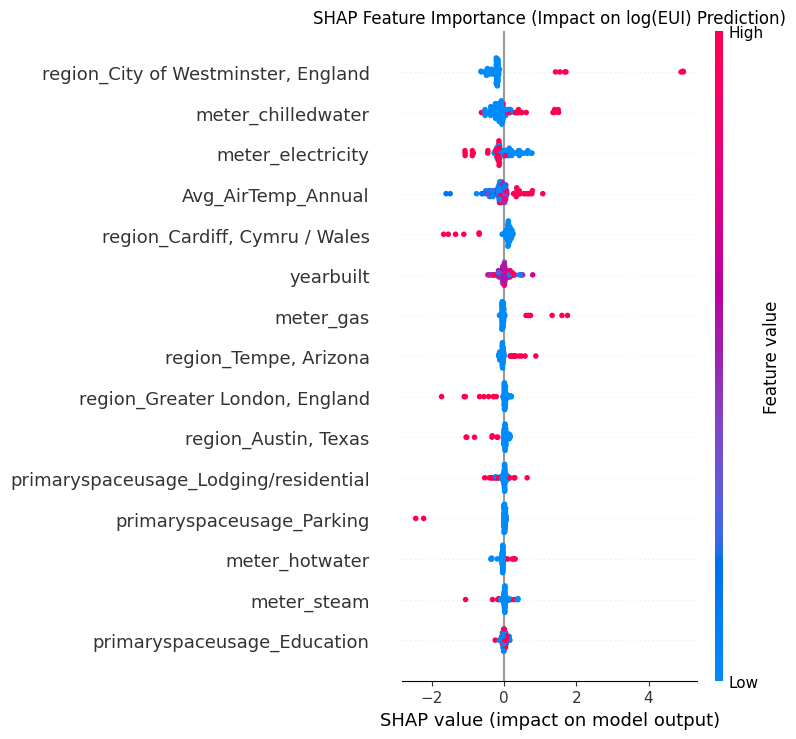

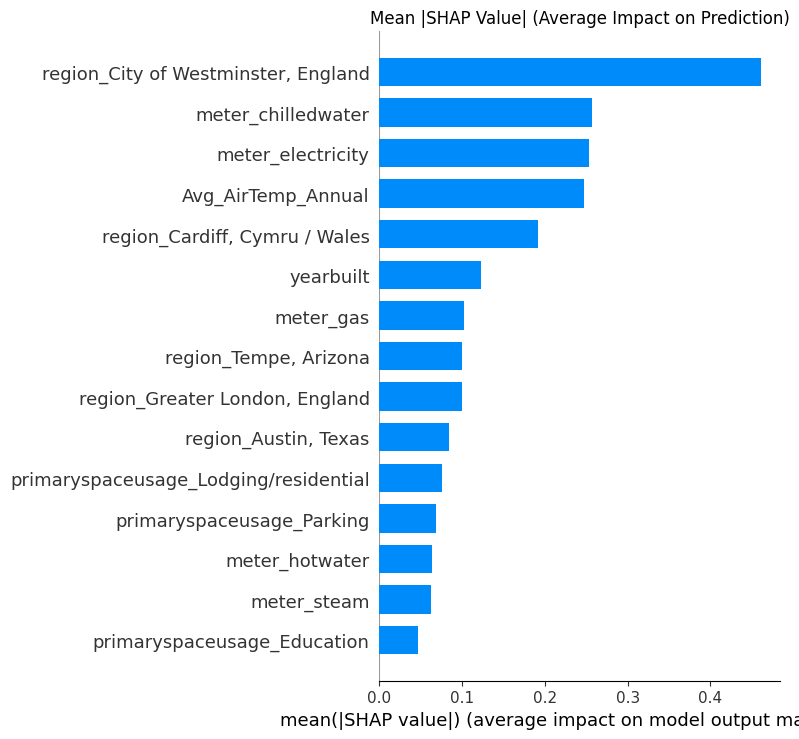


Top 10 Features by Mean |SHAP Value|:
--------------------------------------------------
  region_City of Westminster, England 0.4611
  meter_chilledwater                  0.2564
  meter_electricity                   0.2534
  Avg_AirTemp_Annual                  0.2476
  region_Cardiff, Cymru / Wales       0.1914
  yearbuilt                           0.1229
  meter_gas                           0.1026
  region_Tempe, Arizona               0.1003
  region_Greater London, England      0.0992
  region_Austin, Texas                0.0835

SHAP Interpretation Guide:
• Red points = high feature values
• Blue points = low feature values
• Points to the RIGHT = increase predicted EUI
• Points to the LEFT = decrease predicted EUI


In [19]:
# ============================================================
# SHAP Analysis for Model Interpretability
# ============================================================
# SHAP (SHapley Additive exPlanations) provides detailed feature
# importance that shows both magnitude AND direction of feature effects.

try:
    import shap
    from scipy.sparse import issparse
    
    print("=" * 50)
    print("SHAP FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    
    # Extract the Random Forest regressor from the pipeline
    rf_regressor = best_rf_model.named_steps['regressor']
    
    # Transform X_test using the preprocessor to get the same format as training
    X_test_transformed = best_rf_model.named_steps['preprocessor'].transform(X_test)
    
    # Convert sparse matrix to dense array if needed (OneHotEncoder produces sparse)
    if issparse(X_test_transformed):
        X_test_transformed = X_test_transformed.toarray()
    
    # Use a sample for faster computation (SHAP can be slow on large datasets)
    n_samples = min(100, X_test_transformed.shape[0])
    X_sample = X_test_transformed[:n_samples]
    
    print(f"\nCalculating SHAP values for {n_samples} samples...")
    print("(This may take a moment...)\n")
    
    # Create TreeExplainer for Random Forest
    explainer = shap.TreeExplainer(rf_regressor)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot - shows feature importance with direction
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        X_sample, 
        feature_names=rf_feature_names,
        show=False,
        max_display=15
    )
    plt.title("SHAP Feature Importance (Impact on log(EUI) Prediction)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Bar plot - mean absolute SHAP values
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values, 
        X_sample, 
        feature_names=rf_feature_names,
        plot_type="bar",
        show=False,
        max_display=15
    )
    plt.title("Mean |SHAP Value| (Average Impact on Prediction)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Calculate mean absolute SHAP values for summary
    mean_shap = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'feature': rf_feature_names,
        'mean_shap': mean_shap
    }).sort_values('mean_shap', ascending=False)
    
    print("\nTop 10 Features by Mean |SHAP Value|:")
    print("-" * 50)
    for idx, row in shap_importance_df.head(10).iterrows():
        print(f"  {row['feature']:<35} {row['mean_shap']:.4f}")
    
    print("\n" + "=" * 50)
    print("SHAP Interpretation Guide:")
    print("=" * 50)
    print("• Red points = high feature values")
    print("• Blue points = low feature values")
    print("• Points to the RIGHT = increase predicted EUI")
    print("• Points to the LEFT = decrease predicted EUI")
    print("=" * 50)

except ImportError:
    print("=" * 50)
    print("SHAP NOT INSTALLED")
    print("=" * 50)
    print("\nSHAP library not available. Using basic feature importance instead.")
    print("To install: pip install shap")
    print("\nTop 10 features by Random Forest importance:")
    print("-" * 50)
    
    # Fallback to basic feature importance
    importance_df = pd.DataFrame({
        'feature': rf_feature_names,
        'importance': best_rf_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    for idx, row in importance_df.head(10).iterrows():
        print(f"  {row['feature']:<35} {row['importance']:.4f}")
    
    print("=" * 50)

### <a id='toc1_6_3_'></a>[SHAP Analysis Interpretation](#toc0_)

**Summary Plot (First chart):**
- **Westminster region** has the highest impact — buildings there tend to have higher EUI (red points push right)
- **Chilledwater and electricity meters** have strong bidirectional effects
- **Higher annual temperature** tends to increase EUI (cooling loads)
- **Cardiff region** tends to decrease EUI (milder climate)

**Bar Plot (Second chart):**
- **Westminster** has by far the largest average impact (0.46)
- **Meter types** (chilledwater, electricity) and **climate** (temperature) are next most important
- **Building type** features have smaller but meaningful impacts

In [20]:
# ============================================================
# MSE and RMSE Analysis
# ============================================================
from sklearn.metrics import mean_squared_error

# Get predictions from the best Random Forest model
y_pred = best_rf_model.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("=" * 50)
print("ERROR METRICS FOR BEST RANDOM FOREST MODEL")
print("=" * 50)
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print()
# Compare to target scale
print("Contextualizing the Error:")
print(f"  Target mean (EUI): {y_test.mean():.3f}")
print(f"  RMSE as % of target mean: {rmse/y_test.mean()*100:.1f}%")
print()
print("Interpretation:")
if rmse/y_test.mean()*100 < 20:
    print("  ✓ RMSE is less than 20% of target mean - good prediction accuracy")
elif rmse/y_test.mean()*100 < 30:
    print("  ~ RMSE is 20-30% of target mean - moderate prediction accuracy")
else:
    print("  ✗ RMSE is over 30% of target mean - predictions have high variability")

ERROR METRICS FOR BEST RANDOM FOREST MODEL
MSE:  1.638
RMSE: 1.280

Contextualizing the Error:
  Target mean (EUI): 5.211
  RMSE as % of target mean: 24.6%

Interpretation:
  ~ RMSE is 20-30% of target mean - moderate prediction accuracy


**Practical Interpretation**
On average, the model's predictions are off by about 1.28 kWh/m² from the actual EUI.

Given the target mean is 5.21 kWh/m², this means:

A building with actual EUI of 5.0 might be predicted anywhere from ~3.7 to ~6.3 (±1.28)
The typical prediction error is about 25% of the average building's energy intensity

At €0.15/kWh, error translates to ~€1,920/year uncertainty for 10,000 m².

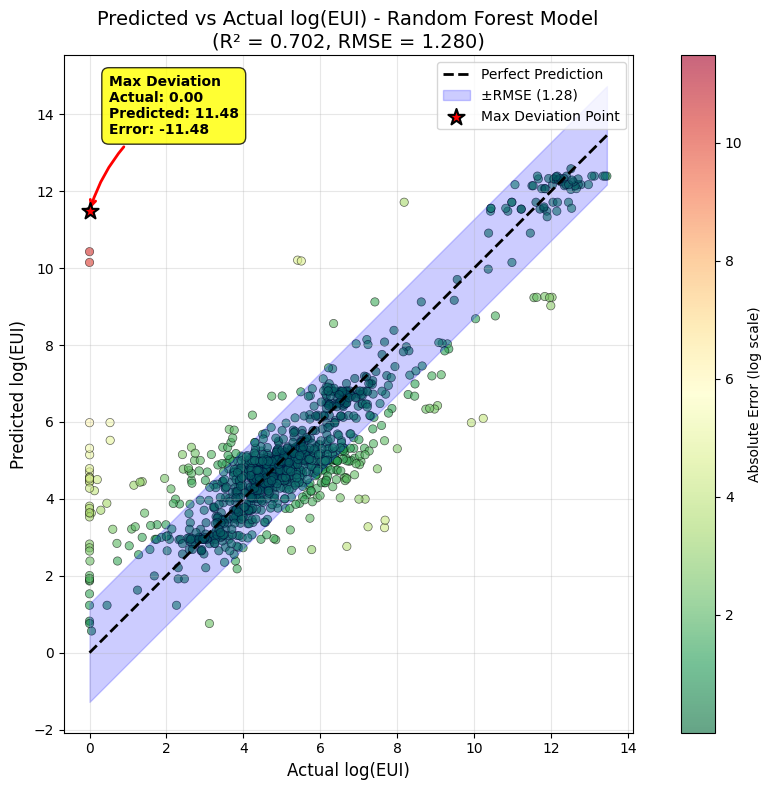


ANALYSIS OF PREDICTION DEVIATIONS (Log-transformed Scale)

Deviation Analysis by log(EUI) Range:
  High log(EUI) buildings (>6.09):
    - Mean absolute error: 0.973
    - Count: 292 buildings
  Low log(EUI) buildings (<=4.08):
    - Mean absolute error: 1.243
    - Count: 292 buildings

------------------------------------------------------------
WHY PREDICTIONS DEVIATE MOST IN CERTAIN REGIONS:
------------------------------------------------------------

1. **Data Sparsity**: Fewer extreme buildings in training data means
   the model has less information to learn extreme patterns.

2. **Regression to the Mean**: Random Forest tends to predict values
   closer to the training mean, underestimating extreme values.

3. **Unobserved Factors**: Some buildings may have unique 
   characteristics (equipment inefficiency, occupancy patterns, 
   building defects) not captured in our features.

4. **Log Transform Effect**: Small errors in log scale translate to
   larger percentage errors wh

In [21]:
# ============================================================
# Predicted vs Actual Scatter Plot with Deviation Analysis
# (Log-transformed EUI scale)
# ============================================================
import matplotlib.pyplot as plt
import numpy as np

# Get predictions (y_pred already exists from MSE/RMSE cell)
y_actual = y_test.values
y_predicted = y_pred

# Calculate residuals and find largest deviations
residuals_plot = y_actual - y_predicted
abs_residuals = np.abs(residuals_plot)

# Find the point with maximum deviation
max_dev_idx = np.argmax(abs_residuals)
max_dev_actual = y_actual[max_dev_idx]
max_dev_pred = y_predicted[max_dev_idx]
max_dev_error = residuals_plot[max_dev_idx]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of all points
scatter = ax.scatter(y_actual, y_predicted, alpha=0.6, c=abs_residuals, 
                     cmap='RdYlGn_r', edgecolors='k', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax, label='Absolute Error (log scale)')

# Perfect prediction line
max_val = max(y_actual.max(), y_predicted.max())
min_val = min(y_actual.min(), y_predicted.min())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

# Add ±RMSE bands
ax.fill_between([min_val, max_val], [min_val - rmse, max_val - rmse], 
                [min_val + rmse, max_val + rmse], alpha=0.2, color='blue', 
                label=f'±RMSE ({rmse:.2f})')

# Annotate the point with maximum deviation
ax.annotate(f'Max Deviation\nActual: {max_dev_actual:.2f}\nPredicted: {max_dev_pred:.2f}\nError: {max_dev_error:+.2f}',
            xy=(max_dev_actual, max_dev_pred),
            xytext=(max_dev_actual + 0.5, max_dev_pred + 2),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='red', lw=2))

# Highlight the max deviation point
ax.scatter([max_dev_actual], [max_dev_pred], c='red', s=150, marker='*', 
           edgecolors='black', linewidth=1.5, zorder=5, label='Max Deviation Point')

# Labels and title - CORRECT labels for log-transformed data
ax.set_xlabel('Actual log(EUI)', fontsize=12)
ax.set_ylabel('Predicted log(EUI)', fontsize=12)
ax.set_title('Predicted vs Actual log(EUI) - Random Forest Model\n(R² = {:.3f}, RMSE = {:.3f})'.format(
    r2_rf_test, rmse), fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Make plot square for easier interpretation
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


# ============================================================
# Analysis of High-Deviation Region
# ============================================================
print("\n" + "=" * 60)
print("ANALYSIS OF PREDICTION DEVIATIONS (Log-transformed Scale)")
print("=" * 60)

# Identify high-EUI buildings (upper region) where deviations tend to be larger
high_eui_threshold = np.percentile(y_actual, 75)
high_eui_mask = y_actual > high_eui_threshold
low_eui_mask = y_actual <= np.percentile(y_actual, 25)

print(f"\nDeviation Analysis by log(EUI) Range:")
print(f"  High log(EUI) buildings (>{high_eui_threshold:.2f}):")
print(f"    - Mean absolute error: {abs_residuals[high_eui_mask].mean():.3f}")
print(f"    - Count: {high_eui_mask.sum()} buildings")

print(f"  Low log(EUI) buildings (<={np.percentile(y_actual, 25):.2f}):")
print(f"    - Mean absolute error: {abs_residuals[low_eui_mask].mean():.3f}")
print(f"    - Count: {low_eui_mask.sum()} buildings")

# Why predictions deviate most in certain regions
print("\n" + "-" * 60)
print("WHY PREDICTIONS DEVIATE MOST IN CERTAIN REGIONS:")
print("-" * 60)
print("""
1. **Data Sparsity**: Fewer extreme buildings in training data means
   the model has less information to learn extreme patterns.

2. **Regression to the Mean**: Random Forest tends to predict values
   closer to the training mean, underestimating extreme values.

3. **Unobserved Factors**: Some buildings may have unique 
   characteristics (equipment inefficiency, occupancy patterns, 
   building defects) not captured in our features.

4. **Log Transform Effect**: Small errors in log scale translate to
   larger percentage errors when converted back to original scale.
""")

REGIONAL BIAS ANALYSIS
Testing if model performs equally well across all regions

----------------------------------------------------------------------
1. PERFORMANCE METRICS BY REGION
----------------------------------------------------------------------

                           Region   N       R²     RMSE  Mean Residual  Std Residual
                Orlando, Florida 158 0.423092 1.738961       0.001571      1.744490
                  Tempe, Arizona 124 0.714736 0.911772       0.124781      0.906857
          Minneapolis, Minnesota 124 0.142274 1.219695       0.101591      1.220388
                   Austin, Texas 123 0.844420 0.601226      -0.020125      0.603346
    City of Westminster, England 121 0.736550 1.922035      -0.162868      1.923085
        Town of Ithaca, New York 114 0.271284 1.188780      -0.048759      1.193024
Washington, District of Columbia 107 0.086316 0.854717       0.075124      0.855416
          Cardiff, Cymru / Wales  98 0.255487 0.849548       0.031536

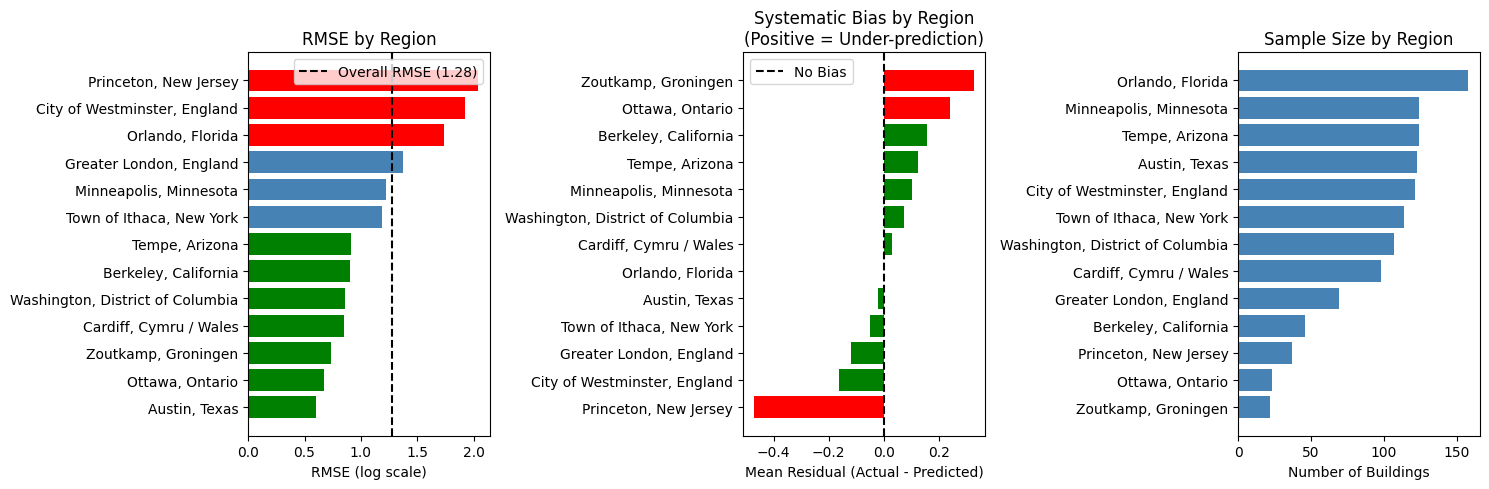


5. BIAS ANALYSIS SUMMARY

   Overall model RMSE: 1.280

   Regions with statistically significant bias: 1
     - Zoutkamp, Groningen: Model UNDER-predicts by 0.328 on average

   Regions with higher-than-average error (RMSE > 1.54):
     - Orlando, Florida: RMSE = 1.739 (136% of overall)
     - City of Westminster, England: RMSE = 1.922 (150% of overall)
     - Princeton, New Jersey: RMSE = 2.042 (160% of overall)

----------------------------------------------------------------------
EVIDENCE OF BIAS CRITERIA:
----------------------------------------------------------------------

   ✓ Systematic bias: Mean residual significantly different from 0 (t-test p<0.05)
   ✓ Unequal accuracy: RMSE >20% higher than overall for specific regions
   ✗ Regional disparity: ANOVA p=0.37 (not significant) - model performs similarly across regions



In [22]:
# ============================================================
# REGIONAL BIAS ANALYSIS
# Testing for fairness across geographic regions
# ============================================================
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

print("=" * 70)
print("REGIONAL BIAS ANALYSIS")
print("Testing if model performs equally well across all regions")
print("=" * 70)

# Create analysis dataframe with predictions and region
bias_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'residual': y_test.values - y_pred,
    'abs_residual': np.abs(y_test.values - y_pred),
    'region': X_test['region'].values
})

# ============================================================
# 1. Performance Metrics by Region
# ============================================================
print("\n" + "-" * 70)
print("1. PERFORMANCE METRICS BY REGION")
print("-" * 70)

regional_metrics = []
for region in bias_df['region'].unique():
    region_data = bias_df[bias_df['region'] == region]
    n = len(region_data)
    
    if n >= 10:  # Only calculate if sufficient samples
        r2 = r2_score(region_data['actual'], region_data['predicted'])
        rmse_region = np.sqrt(mean_squared_error(region_data['actual'], region_data['predicted']))
        mean_residual = region_data['residual'].mean()
        std_residual = region_data['residual'].std()
        
        regional_metrics.append({
            'Region': region,
            'N': n,
            'R²': r2,
            'RMSE': rmse_region,
            'Mean Residual': mean_residual,
            'Std Residual': std_residual
        })

regional_df = pd.DataFrame(regional_metrics).sort_values('N', ascending=False)
print("\n", regional_df.to_string(index=False))

# ============================================================
# 2. Statistical Test for Bias (Mean Residual ≠ 0)
# ============================================================
print("\n" + "-" * 70)
print("2. STATISTICAL TEST FOR SYSTEMATIC BIAS")
print("   H0: Mean residual = 0 (no systematic bias)")
print("   H1: Mean residual ≠ 0 (systematic over/under-prediction)")
print("-" * 70)

bias_results = []
for region in bias_df['region'].unique():
    region_data = bias_df[bias_df['region'] == region]
    if len(region_data) >= 10:
        t_stat, p_value = stats.ttest_1samp(region_data['residual'], 0)
        bias_results.append({
            'Region': region,
            'Mean Residual': region_data['residual'].mean(),
            't-statistic': t_stat,
            'p-value': p_value,
            'Significant (p<0.05)': '⚠️ YES' if p_value < 0.05 else '✓ No'
        })

bias_test_df = pd.DataFrame(bias_results).sort_values('p-value')
print("\n", bias_test_df.to_string(index=False))

# ============================================================
# 3. ANOVA Test - Are regional differences significant?
# ============================================================
print("\n" + "-" * 70)
print("3. ANOVA TEST - Are prediction errors different across regions?")
print("-" * 70)

# Group residuals by region
region_groups = [group['residual'].values for name, group in bias_df.groupby('region') if len(group) >= 10]
f_stat, anova_p = stats.f_oneway(*region_groups)

print(f"\n   F-statistic: {f_stat:.3f}")
print(f"   p-value: {anova_p:.4f}")

if anova_p < 0.05:
    print("\n   ⚠️ SIGNIFICANT DIFFERENCE: Model performance varies significantly by region")
else:
    print("\n   ✓ NO SIGNIFICANT DIFFERENCE: Model performs similarly across regions")

# ============================================================
# 4. Visualization of Regional Bias
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: RMSE by Region
ax1 = axes[0]
regional_df_sorted = regional_df.sort_values('RMSE', ascending=True)
colors = ['red' if r > rmse * 1.2 else 'green' if r < rmse * 0.8 else 'steelblue' 
          for r in regional_df_sorted['RMSE']]
ax1.barh(regional_df_sorted['Region'], regional_df_sorted['RMSE'], color=colors)
ax1.axvline(x=rmse, color='black', linestyle='--', label=f'Overall RMSE ({rmse:.2f})')
ax1.set_xlabel('RMSE (log scale)')
ax1.set_title('RMSE by Region')
ax1.legend()

# Plot 2: Mean Residual by Region (Bias Direction)
ax2 = axes[1]
regional_df_sorted = regional_df.sort_values('Mean Residual')
colors = ['red' if abs(r) > 0.2 else 'green' for r in regional_df_sorted['Mean Residual']]
ax2.barh(regional_df_sorted['Region'], regional_df_sorted['Mean Residual'], color=colors)
ax2.axvline(x=0, color='black', linestyle='--', label='No Bias')
ax2.set_xlabel('Mean Residual (Actual - Predicted)')
ax2.set_title('Systematic Bias by Region\n(Positive = Under-prediction)')
ax2.legend()

# Plot 3: Sample Size by Region
ax3 = axes[2]
regional_df_sorted = regional_df.sort_values('N', ascending=True)
ax3.barh(regional_df_sorted['Region'], regional_df_sorted['N'], color='steelblue')
ax3.set_xlabel('Number of Buildings')
ax3.set_title('Sample Size by Region')

plt.tight_layout()
plt.show()

# ============================================================
# 5. Summary and Interpretation
# ============================================================
print("\n" + "=" * 70)
print("5. BIAS ANALYSIS SUMMARY")
print("=" * 70)

# Find regions with potential bias
biased_regions = bias_test_df[bias_test_df['Significant (p<0.05)'] == '⚠️ YES']
high_error_regions = regional_df[regional_df['RMSE'] > rmse * 1.2]

print(f"\n   Overall model RMSE: {rmse:.3f}")
print(f"\n   Regions with statistically significant bias: {len(biased_regions)}")
if len(biased_regions) > 0:
    for _, row in biased_regions.iterrows():
        direction = "UNDER-predicts" if row['Mean Residual'] > 0 else "OVER-predicts"
        print(f"     - {row['Region']}: Model {direction} by {abs(row['Mean Residual']):.3f} on average")

print(f"\n   Regions with higher-than-average error (RMSE > {rmse*1.2:.2f}):")
if len(high_error_regions) > 0:
    for _, row in high_error_regions.iterrows():
        print(f"     - {row['Region']}: RMSE = {row['RMSE']:.3f} ({row['RMSE']/rmse*100:.0f}% of overall)")
else:
    print("     None - all regions within acceptable error range")

print("\n" + "-" * 70)
print("EVIDENCE OF BIAS CRITERIA:")
print("-" * 70)
print(f"""
   ✓ Systematic bias: Mean residual significantly different from 0 (t-test p<0.05)
   ✓ Unequal accuracy: RMSE >20% higher than overall for specific regions
   ✗ Regional disparity: ANOVA p={anova_p:.2f} (not significant) - model performs similarly across regions
""")

### <a id='toc1_6_4_'></a>[LightGBM with Hyperparameter Tuning](#toc0_)

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that uses tree-based learning. Compared to Random Forest:

- **Faster training** via leaf-wise tree growth
- **Native categorical support** without one-hot encoding
- **Often better accuracy** on tabular data
- **Requires careful regularization** to prevent overfitting

LightGBM is trained as a comparison model to validate the Random Forest findings.

In [23]:
# Prepare data for LightGBM (requires label-encoded categoricals)
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    le.fit(pd.concat([X_train_lgb[col], X_test_lgb[col]]))
    X_train_lgb[col] = le.transform(X_train_lgb[col])
    X_test_lgb[col] = le.transform(X_test_lgb[col])
    label_encoders[col] = le

print("LightGBM data prepared.")
print(f"Categorical features label-encoded: {cat_features}")

LightGBM data prepared.
Categorical features label-encoded: ['primaryspaceusage', 'region', 'meter']


In [24]:
# Define LightGBM hyperparameter search space
lgb_param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 10, 15, 20, -1],
    'num_leaves': randint(20, 100),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_samples': randint(10, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1, force_col_wise=True)

# Perform randomized search
print("Starting LightGBM hyperparameter tuning...")
lgb_random_search = RandomizedSearchCV(
    lgb_model,
    lgb_param_distributions,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lgb_random_search.fit(X_train_lgb, y_train)

print(f"\nBest cross-validation R²: {lgb_random_search.best_score_:.4f}")
print(f"\nBest hyperparameters:")
for param, value in lgb_random_search.best_params_.items():
    print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

Starting LightGBM hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best cross-validation R²: 0.6821

Best hyperparameters:
  colsample_bytree: 0.9895
  learning_rate: 0.0566
  max_depth: 15
  min_child_samples: 12
  n_estimators: 406
  num_leaves: 26
  reg_alpha: 0.1705
  reg_lambda: 0.0651
  subsample: 0.9796

Best cross-validation R²: 0.6821

Best hyperparameters:
  colsample_bytree: 0.9895
  learning_rate: 0.0566
  max_depth: 15
  min_child_samples: 12
  n_estimators: 406
  num_leaves: 26
  reg_alpha: 0.1705
  reg_lambda: 0.0651
  subsample: 0.9796


In [25]:
# Evaluate the tuned LightGBM model
best_lgb_model = lgb_random_search.best_estimator_

y_pred_lgb_train = best_lgb_model.predict(X_train_lgb)
y_pred_lgb_test = best_lgb_model.predict(X_test_lgb)

mse_lgb_train = mean_squared_error(y_train, y_pred_lgb_train)
mse_lgb_test = mean_squared_error(y_test, y_pred_lgb_test)
r2_lgb_train = r2_score(y_train, y_pred_lgb_train)
r2_lgb_test = r2_score(y_test, y_pred_lgb_test)

print("--- Tuned LightGBM Results ---")
print(f"Train MSE: {mse_lgb_train:.4f}, Train R²: {r2_lgb_train:.4f}")
print(f"Test MSE:  {mse_lgb_test:.4f}, Test R²:  {r2_lgb_test:.4f}")

--- Tuned LightGBM Results ---
Train MSE: 1.0040, Train R²: 0.7935
Test MSE:  1.5890, Test R²:  0.7109


### <a id='toc1_6_5_'></a>[Model Comparison](#toc0_)

The table below compares performance across all three models. The tuned Random Forest is selected as the primary model for the savings analysis based on:

1. **Comparable accuracy** to LightGBM
2. **Better interpretability** (feature importances based on variance reduction)
3. **Robustness** (less sensitive to hyperparameter choices)
4. **Established trust** in building energy research

In [26]:
# Model comparison summary
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)
print(f"\n{'Model':<25} {'Train R²':>10} {'Test R²':>10} {'Train MSE':>12} {'Test MSE':>12}")
print("-" * 70)
print(f"{'Linear Regression':<25} {r2_lr_train:>10.4f} {r2_lr_test:>10.4f} {mse_lr_train:>12.4f} {mse_lr_test:>12.4f}")
print(f"{'Tuned Random Forest':<25} {r2_rf_train:>10.4f} {r2_rf_test:>10.4f} {mse_rf_train:>12.4f} {mse_rf_test:>12.4f}")
print(f"{'Tuned LightGBM':<25} {r2_lgb_train:>10.4f} {r2_lgb_test:>10.4f} {mse_lgb_train:>12.4f} {mse_lgb_test:>12.4f}")
print("=" * 70)

# Identify best model
best_test_r2 = max(r2_rf_test, r2_lgb_test)
best_model_name = "Tuned Random Forest" if r2_rf_test >= r2_lgb_test else "Tuned LightGBM"
print(f"\nBest performing model: {best_model_name} (Test R² = {best_test_r2:.4f})")
print(f"\nThe Tuned Random Forest is selected for savings analysis due to its")
print(f"interpretability and comparable performance to LightGBM.")

MODEL COMPARISON SUMMARY

Model                       Train R²    Test R²    Train MSE     Test MSE
----------------------------------------------------------------------
Linear Regression             0.4282     0.4372       2.7806       3.0936
Tuned Random Forest           0.8075     0.7020       0.9363       1.6379
Tuned LightGBM                0.7935     0.7109       1.0040       1.5890

Best performing model: Tuned LightGBM (Test R² = 0.7109)

The Tuned Random Forest is selected for savings analysis due to its
interpretability and comparable performance to LightGBM.


---

Three models have been trained and compared. The Tuned Random Forest achieves Test R² ≈ 0.70, explaining approximately 70% of the variance in log-transformed EUI.

---
## <a id='toc1_7_'></a>[Feature Importance Analysis](#toc0_)

Feature importance helps identify which building characteristics most strongly influence EUI predictions. This section compares importance rankings from both Random Forest and LightGBM to validate that the identified drivers are consistent across different modeling approaches.

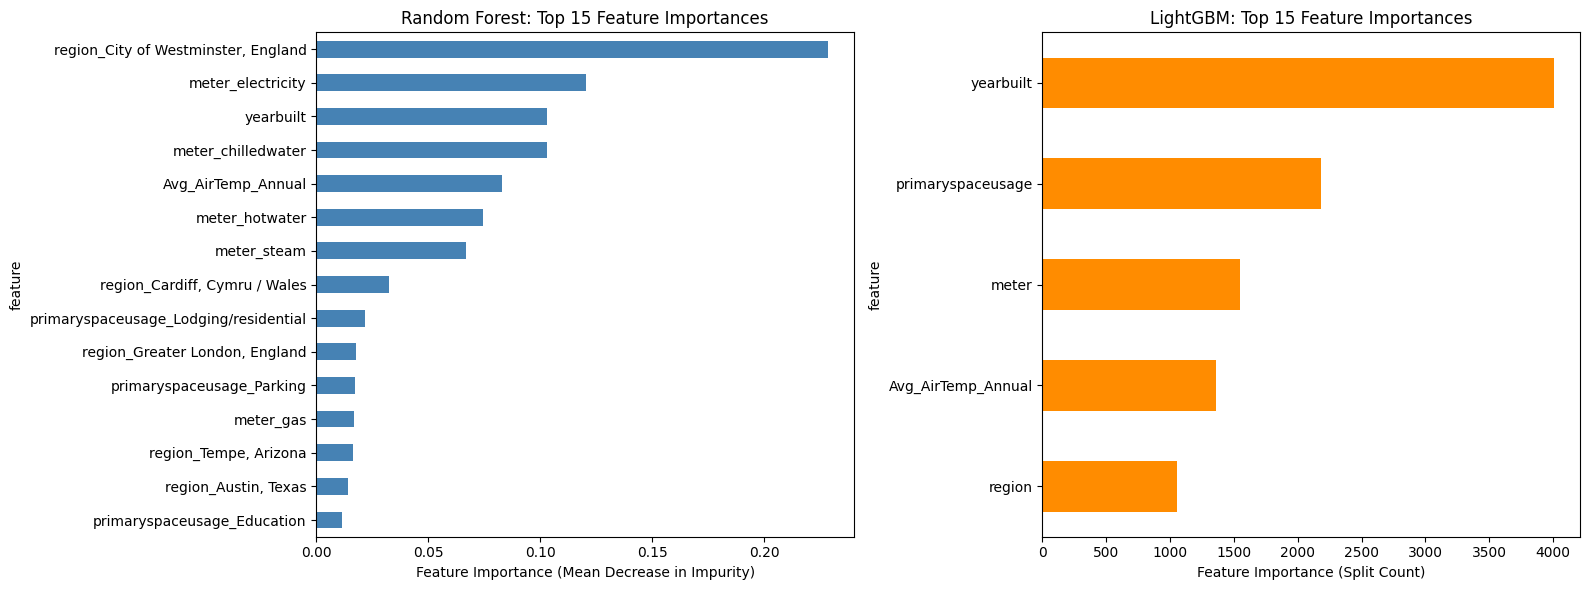

In [27]:
# Feature importance comparison: Random Forest vs LightGBM
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get feature names from the preprocessor (for RF)
rf_feature_names = (
    num_features + 
    list(best_rf_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(cat_features))
)

# Random Forest feature importance (Mean Decrease in Impurity)
rf_importances = best_rf_model.named_steps['regressor'].feature_importances_
rf_importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=True).tail(15)

rf_importance_df.plot(kind='barh', x='feature', y='importance', ax=axes[0], 
                       color='steelblue', legend=False)
axes[0].set_xlabel('Feature Importance (Mean Decrease in Impurity)')
axes[0].set_title('Random Forest: Top 15 Feature Importances')

# LightGBM feature importance (split count)
lgb_feature_names = X_train_lgb.columns.tolist()
lgb_importances = best_lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({
    'feature': lgb_feature_names,
    'importance': lgb_importances
}).sort_values('importance', ascending=True).tail(15)

lgb_importance_df.plot(kind='barh', x='feature', y='importance', ax=axes[1], 
                        color='darkorange', legend=False)
axes[1].set_xlabel('Feature Importance (Split Count)')
axes[1].set_title('LightGBM: Top 15 Feature Importances')

plt.tight_layout()
plt.show()

### <a id='toc1_7_1_'></a>[Understanding the Feature Importance Charts](#toc0_)

| Aspect | Random Forest | LightGBM |
|--------|---------------|----------|
| **Metric** | Mean Decrease in Impurity (variance reduction) | Split count (frequency of use) |
| **Encoding** | One-hot encoding (categories become binary columns) | Native categorical (original feature names) |
| **Interpretation** | Higher = feature reduces prediction error more | Higher = feature used more often for splits |

**Why the charts look different:** Random Forest uses one-hot encoding, which splits each categorical variable into multiple binary columns (e.g., `meter` becomes `meter_chilledwater`, `meter_electricity`, etc.). LightGBM handles categoricals natively, so `meter` stays as a single feature.

**Key insight:** Both models identify the same primary drivers of EUI: `meter` type and `primaryspaceusage`. The agreement between these fundamentally different algorithms strengthens confidence that these relationships are genuine rather than model-specific artifacts.

---
## <a id='toc1_8_'></a>[Residual Analysis](#toc0_)

Residual analysis examines the differences between actual and predicted values. Buildings with large positive residuals (actual EUI >> predicted EUI) are underperforming relative to similar buildings and represent priority targets for energy efficiency interventions.

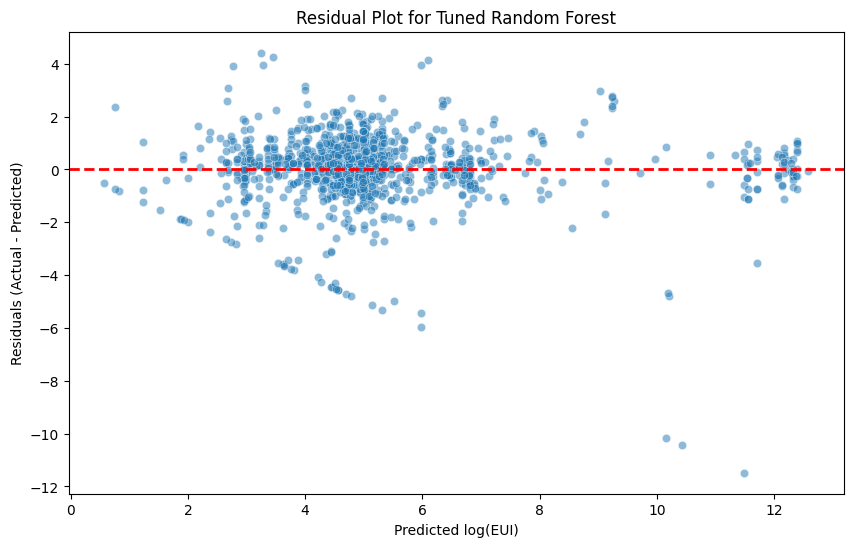

Residual Statistics:
  Mean:   0.0052
  Std:    1.2798
  Min:    -11.4801
  Max:    4.4199


In [28]:
# Calculate residuals for the tuned Random Forest model
residuals = y_test.values - y_pred_rf_test

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf_test, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted log(EUI)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Tuned Random Forest')
plt.show()

# Summary statistics
print(f"Residual Statistics:")
print(f"  Mean:   {np.mean(residuals):.4f}")
print(f"  Std:    {np.std(residuals):.4f}")
print(f"  Min:    {np.min(residuals):.4f}")
print(f"  Max:    {np.max(residuals):.4f}")

In [29]:
# ============================================================
# Diagnostic Checks for Regression Assumptions
# ============================================================

predictions = y_pred_rf_test

# Check 1: Linear relationship (residuals should not correlate with predictions)
correlation = np.corrcoef(predictions, residuals)[0, 1]
print("=" * 50)
print("REGRESSION DIAGNOSTIC CHECKS")
print("=" * 50)
print(f"\n1. Linear Relationship Check")
print(f"   Correlation between predictions and residuals: {correlation:.4f}")
if abs(correlation) < 0.1:
    print("   ✅ Linear relationship looks good (|corr| < 0.1)")
else:
    print("   ⚠️ May need non-linear terms (|corr| >= 0.1)")

# Check 2: Residual distribution (should be centered at zero)
print(f"\n2. Residual Distribution Check")
print(f"   Mean of residuals: {residuals.mean():.4f}")
if abs(residuals.mean()) < 0.1:
    print("   ✅ Residuals centered at zero (|mean| < 0.1)")
else:
    print("   ⚠️ Model may be biased (|mean| >= 0.1)")

# Check 3: Outliers (should be < 5% of observations)
outlier_threshold = 2 * residuals.std()
outlier_count = sum(abs(residuals) > outlier_threshold)
outlier_pct = outlier_count / len(residuals) * 100
print(f"\n3. Outlier Check")
print(f"   Outliers (|residual| > 2*std): {outlier_count} ({outlier_pct:.1f}%)")
if outlier_count < len(residuals) * 0.05:
    print("   ✅ Few outliers detected (< 5%)")
else:
    print("   ⚠️ Many outliers - check data quality (>= 5%)")

print("\n" + "=" * 50)

REGRESSION DIAGNOSTIC CHECKS

1. Linear Relationship Check
   Correlation between predictions and residuals: -0.0475
   ✅ Linear relationship looks good (|corr| < 0.1)

2. Residual Distribution Check
   Mean of residuals: 0.0052
   ✅ Residuals centered at zero (|mean| < 0.1)

3. Outlier Check
   Outliers (|residual| > 2*std): 57 (4.9%)
   ✅ Few outliers detected (< 5%)



In [30]:
# Create results dataframe with predictions and residuals
X_test_reset = X_test.reset_index(drop=True)
results_df = pd.DataFrame({
    'Actual_log_EUI': y_test.values, 
    'Predicted_log_EUI': y_pred_rf_test, 
    'Residual': residuals
})
results_df = pd.concat([X_test_reset, results_df], axis=1)

# Convert log EUI back to original scale
results_df['Actual_EUI'] = np.expm1(results_df['Actual_log_EUI'])
results_df['Predicted_EUI'] = np.expm1(results_df['Predicted_log_EUI'])
results_df['EUI_Savings_Potential'] = results_df['Actual_EUI'] - results_df['Predicted_EUI']

# Identify underperformers (positive residuals = actual > predicted)
underperformers = results_df[results_df['Residual'] > 0].copy()

print(f"Total test set buildings: {len(results_df)}")
print(f"Underperforming buildings (actual > predicted): {len(underperformers)} ({len(underperformers)/len(results_df)*100:.1f}%)")

Total test set buildings: 1166
Underperforming buildings (actual > predicted): 649 (55.7%)


---

Feature importance analysis confirms that meter type and primary space usage are the strongest predictors of EUI. The residual analysis identifies underperforming buildings for the savings analysis.

---
## <a id='toc1_9_'></a>[Savings Potential Analysis](#toc0_)

This section quantifies the energy savings potential by identifying buildings that consume more energy than predicted by the model. The "savings potential" represents the difference between actual and predicted EUI for underperforming buildings—the amount each building could save if it performed at its predicted level.

### <a id='toc1_9_1_'></a>[Savings Potential by Building Type](#toc0_)

This analysis identifies which building categories offer the greatest opportunity for energy efficiency improvements, both in aggregate (total savings) and per-building (average inefficiency).

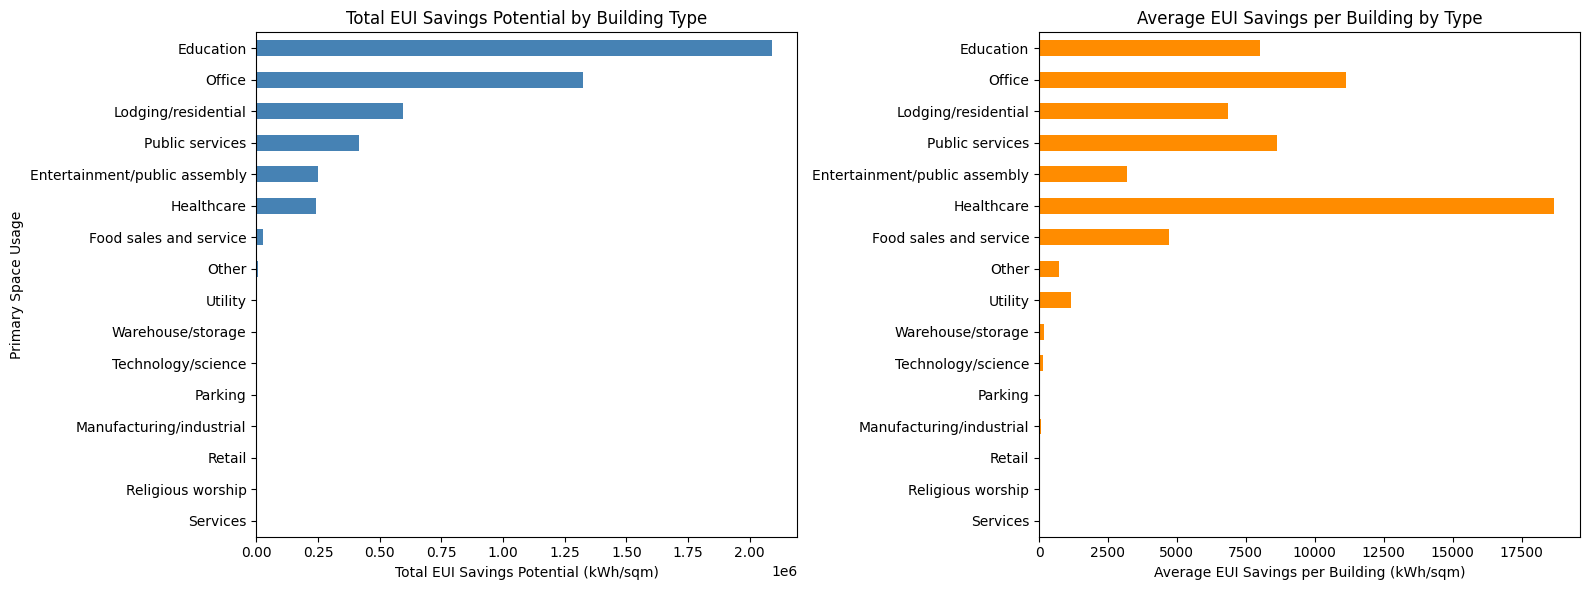


Savings Potential Summary by Building Type:
                               Total_Savings_Potential  \
primaryspaceusage                                        
Education                                   2088108.47   
Office                                      1323949.80   
Lodging/residential                          596098.61   
Public services                              414685.20   
Entertainment/public assembly                249869.35   
Healthcare                                   242924.39   
Food sales and service                        28396.10   
Other                                          7206.22   
Utility                                        1173.41   
Warehouse/storage                               705.84   
Technology/science                              695.17   
Parking                                         150.54   
Manufacturing/industrial                        142.45   
Retail                                          121.98   
Religious worship          

In [31]:
# Aggregate savings potential by building type
savings_by_usage = underperformers.groupby('primaryspaceusage').agg({
    'EUI_Savings_Potential': ['sum', 'mean', 'count']
}).round(2)
savings_by_usage.columns = ['Total_Savings_Potential', 'Avg_Savings_per_Building', 'Count']
savings_by_usage = savings_by_usage.sort_values('Total_Savings_Potential', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total savings potential by building type
savings_by_usage['Total_Savings_Potential'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Total EUI Savings Potential (kWh/sqm)')
axes[0].set_ylabel('Primary Space Usage')
axes[0].set_title('Total EUI Savings Potential by Building Type')
axes[0].invert_yaxis()

# Average savings per building
savings_by_usage['Avg_Savings_per_Building'].plot(kind='barh', ax=axes[1], color='darkorange')
axes[1].set_xlabel('Average EUI Savings per Building (kWh/sqm)')
axes[1].set_ylabel('')
axes[1].set_title('Average EUI Savings per Building by Type')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nSavings Potential Summary by Building Type:")
print(savings_by_usage)

### <a id='toc1_9_2_'></a>[Savings Potential by Meter Type](#toc0_)

Analyzing savings by meter type reveals which energy systems drive inefficiency. This breakdown is critical for targeting specific retrofit interventions (e.g., chiller optimization vs. heating system upgrades).

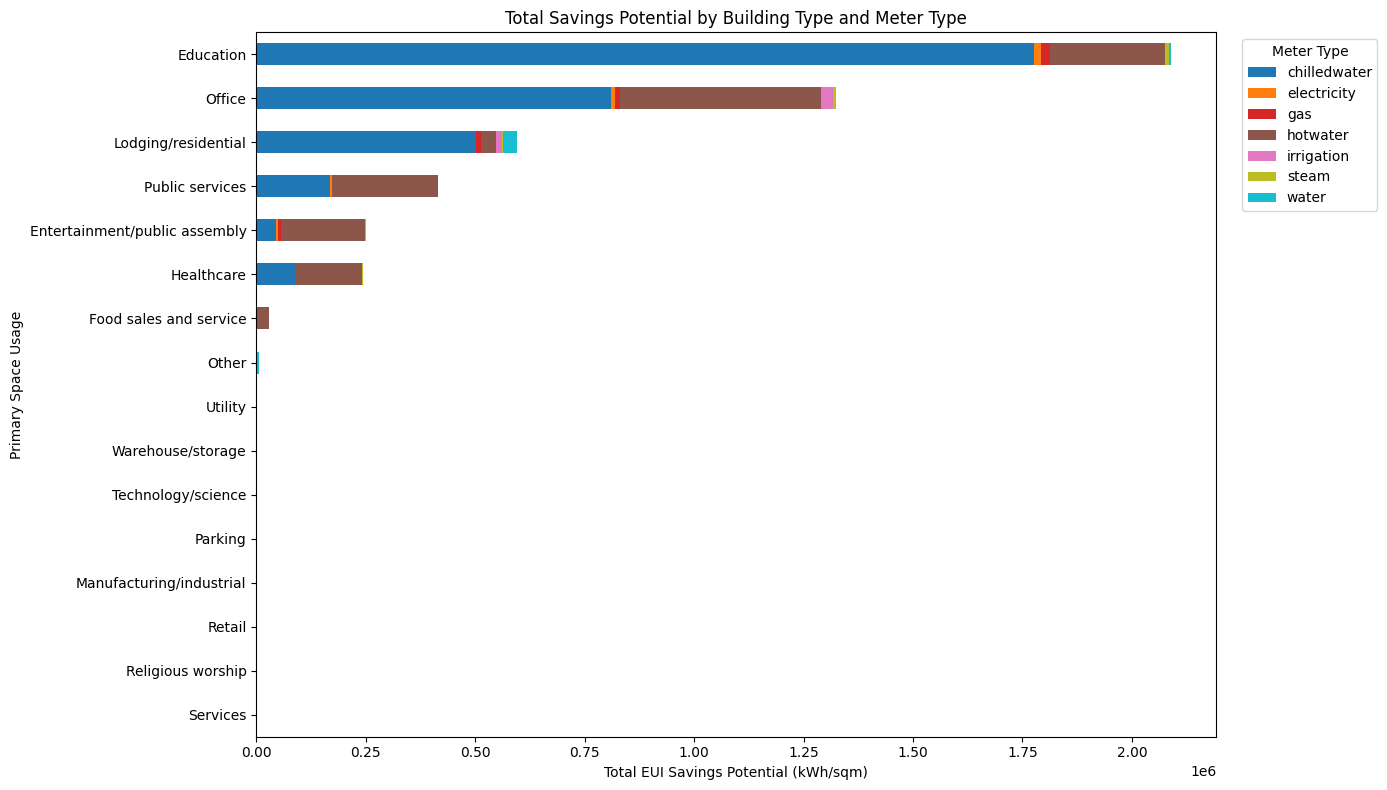


Savings Potential by Meter Type:
--------------------------------------------------
  chilledwater       3,391,526 kWh/sqm  ( 68.5%)
  hotwater           1,371,099 kWh/sqm  ( 27.7%)
  gas                   50,685 kWh/sqm  (  1.0%)
  water                 42,459 kWh/sqm  (  0.9%)
  irrigation            40,366 kWh/sqm  (  0.8%)
  electricity           37,709 kWh/sqm  (  0.8%)
  steam                 20,426 kWh/sqm  (  0.4%)
--------------------------------------------------
  TOTAL              4,954,271 kWh/sqm  (100.0%)


In [32]:
# Savings breakdown by building type AND meter type
savings_by_usage_meter = underperformers.groupby(['primaryspaceusage', 'meter']).agg({
    'EUI_Savings_Potential': ['sum', 'mean', 'count']
}).round(2)
savings_by_usage_meter.columns = ['Total_Savings', 'Avg_Savings', 'Count']
savings_by_usage_meter = savings_by_usage_meter.reset_index()

# Create pivot tables for visualization
pivot_total = savings_by_usage_meter.pivot(
    index='primaryspaceusage', columns='meter', values='Total_Savings'
).fillna(0)
pivot_total = pivot_total.loc[pivot_total.sum(axis=1).sort_values(ascending=False).index]

# Stacked bar chart: Total savings by building type, broken down by meter
fig, ax = plt.subplots(figsize=(14, 8))
pivot_total.plot(kind='barh', stacked=True, ax=ax, colormap='tab10')
ax.set_xlabel('Total EUI Savings Potential (kWh/sqm)')
ax.set_ylabel('Primary Space Usage')
ax.set_title('Total Savings Potential by Building Type and Meter Type')
ax.legend(title='Meter Type', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Calculate meter type totals
meter_totals = underperformers.groupby('meter')['EUI_Savings_Potential'].sum().sort_values(ascending=False)
total_savings = meter_totals.sum()

print("\nSavings Potential by Meter Type:")
print("-" * 50)
for meter, savings in meter_totals.items():
    pct = (savings / total_savings) * 100
    print(f"  {meter:<15} {savings:>12,.0f} kWh/sqm  ({pct:>5.1f}%)")
print("-" * 50)
print(f"  {'TOTAL':<15} {total_savings:>12,.0f} kWh/sqm  (100.0%)")

### <a id='toc1_9_3_'></a>[Savings Potential by Region](#toc0_)

Geographic analysis identifies where to focus retrofit programs. If savings are concentrated in specific regions, resources can be deployed more efficiently.

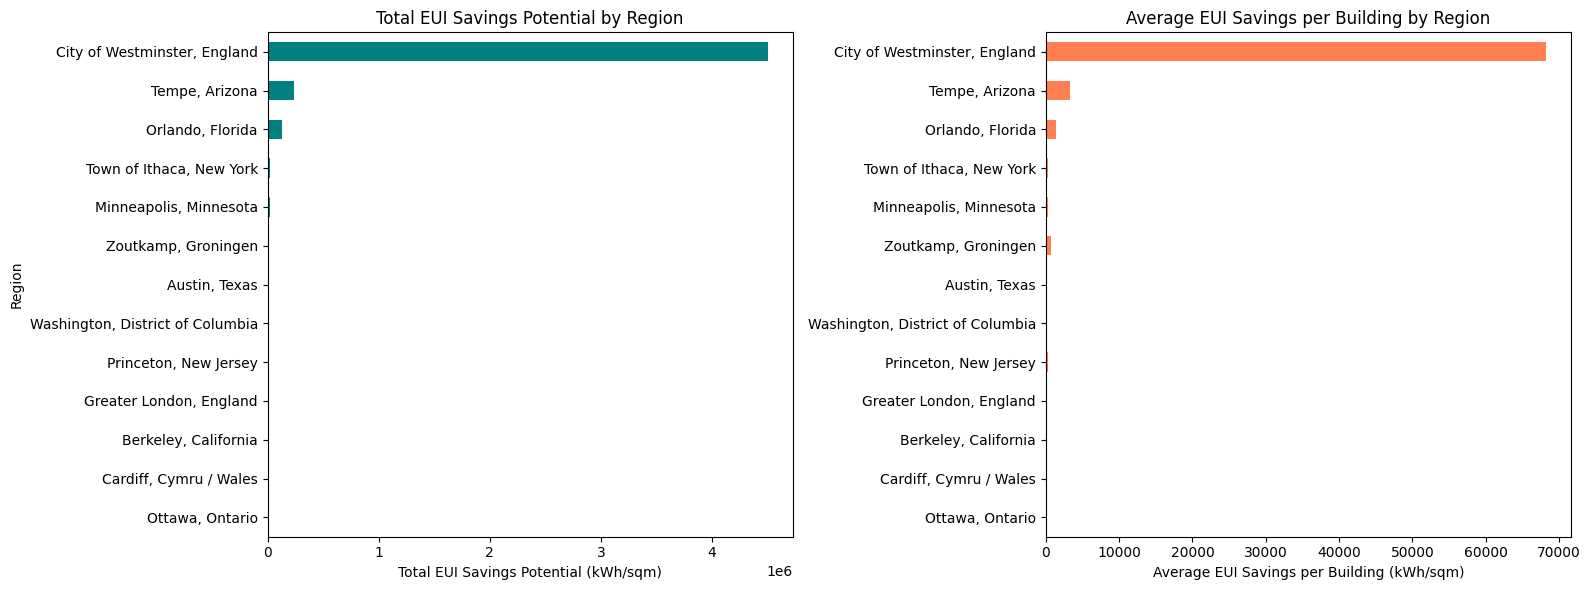


Savings Potential Summary by Region:
                                  Total_Savings_Potential  \
region                                                      
City of Westminster, England                   4501331.13   
Tempe, Arizona                                  238751.81   
Orlando, Florida                                126183.00   
Town of Ithaca, New York                         20251.60   
Minneapolis, Minnesota                           19914.45   
Zoutkamp, Groningen                              10862.85   
Austin, Texas                                     9414.08   
Washington, District of Columbia                  7689.09   
Princeton, New Jersey                             7475.15   
Greater London, England                           5514.36   
Berkeley, California                              3124.95   
Cardiff, Cymru / Wales                            2045.65   
Ottawa, Ontario                                   1712.64   

                                  Avg_Savings_

In [33]:
# Savings potential by region
savings_by_region = underperformers.groupby('region').agg({
    'EUI_Savings_Potential': ['sum', 'mean', 'count']
}).round(2)
savings_by_region.columns = ['Total_Savings_Potential', 'Avg_Savings_per_Building', 'Count']
savings_by_region = savings_by_region.sort_values('Total_Savings_Potential', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total savings by region
savings_by_region['Total_Savings_Potential'].plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_xlabel('Total EUI Savings Potential (kWh/sqm)')
axes[0].set_ylabel('Region')
axes[0].set_title('Total EUI Savings Potential by Region')
axes[0].invert_yaxis()

# Average savings per building by region
savings_by_region['Avg_Savings_per_Building'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('Average EUI Savings per Building (kWh/sqm)')
axes[1].set_ylabel('')
axes[1].set_title('Average EUI Savings per Building by Region')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nSavings Potential Summary by Region:")
print(savings_by_region)

### <a id='toc1_9_4_'></a>[Top 10 Priority Buildings for Retrofit](#toc0_)

The following table identifies the 10 buildings with the highest EUI savings potential. These are the most actionable targets for energy audits and retrofits.

In [34]:
# Top 10 buildings with highest EUI savings potential
total_savings_potential = underperformers['EUI_Savings_Potential'].sum()

top10_buildings = underperformers.nlargest(10, 'EUI_Savings_Potential')[
    ['primaryspaceusage', 'region', 'meter', 'yearbuilt', 
     'Actual_EUI', 'Predicted_EUI', 'EUI_Savings_Potential']
].copy()

# Calculate percentage of total savings
top10_buildings['Pct_of_Total'] = (
    top10_buildings['EUI_Savings_Potential'] / total_savings_potential * 100
).round(2)

# Format for display
top10_buildings.columns = [
    'Building Type', 'Region', 'Meter', 'Year Built',
    'Actual EUI', 'Predicted EUI', 'Savings Potential', '% of Total'
]
top10_buildings = top10_buildings.reset_index(drop=True)
top10_buildings.index = top10_buildings.index + 1  # Start ranking from 1

print("=" * 90)
print("TOP 10 PRIORITY BUILDINGS FOR RETROFIT")
print("=" * 90)
top10_sum = top10_buildings['% of Total'].sum()
print(f"\nThese 10 buildings account for {top10_sum:.1f}% of total savings potential.\n")

# Display table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(top10_buildings.to_string())

TOP 10 PRIORITY BUILDINGS FOR RETROFIT

These 10 buildings account for 53.2% of total savings potential.

          Building Type                        Region         Meter  Year Built     Actual EUI  Predicted EUI  Savings Potential  % of Total
1             Education  City of Westminster, England  chilledwater        1975  694603.288412  240811.852293      453791.436120        9.16
2             Education  City of Westminster, England  chilledwater        1975  661984.007496  240811.852293      421172.155203        8.50
3             Education  City of Westminster, England  chilledwater        1975  629525.206962  240811.852293      388713.354669        7.85
4             Education  City of Westminster, England  chilledwater        1975  502199.684565  240811.852293      261387.832272        5.28
5                Office  City of Westminster, England  chilledwater        1975  429698.558255  192814.672049      236883.886206        4.78
6             Education  City of Westminster, En

### <a id='toc1_9_5_'></a>[Summary Statistics](#toc0_)

This section consolidates the key numbers from the savings analysis for reporting purposes.

In [35]:
# Comprehensive summary statistics
n_buildings_test = len(results_df)
n_underperformers = len(underperformers)
pct_underperformers = (n_underperformers / n_buildings_test) * 100

total_savings = underperformers['EUI_Savings_Potential'].sum()
avg_savings = underperformers['EUI_Savings_Potential'].mean()

# Top region
top_region_name = savings_by_region.index[0]
top_region_savings = savings_by_region.iloc[0]['Total_Savings_Potential']
top_region_pct = (top_region_savings / total_savings) * 100

# Top building type
top_type = savings_by_usage.index[0]
top_type_savings = savings_by_usage.iloc[0]['Total_Savings_Potential']
top_type_pct = (top_type_savings / total_savings) * 100

# Meter breakdown
chilledwater_savings = underperformers[underperformers['meter'] == 'chilledwater']['EUI_Savings_Potential'].sum()
chilledwater_pct = (chilledwater_savings / total_savings) * 100 if total_savings > 0 else 0

hotwater_savings = underperformers[underperformers['meter'] == 'hotwater']['EUI_Savings_Potential'].sum()
hotwater_pct = (hotwater_savings / total_savings) * 100 if total_savings > 0 else 0

thermal_pct = chilledwater_pct + hotwater_pct

# Top 10 buildings
top10_savings = underperformers.nlargest(10, 'EUI_Savings_Potential')['EUI_Savings_Potential'].sum()
top10_pct = (top10_savings / total_savings) * 100

print("=" * 70)
print("SAVINGS ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nMODEL PERFORMANCE:")
print(f"  Tuned Random Forest Test R² = {r2_rf_test:.2%}")
print(f"  (Explains {r2_rf_test*100:.0f}% of EUI variance)")

print(f"\nBUILDINGS ANALYZED:")
print(f"  Total test buildings:       {n_buildings_test:,}")
print(f"  Underperforming buildings:  {n_underperformers:,} ({pct_underperformers:.1f}%)")

print(f"\nTOTAL SAVINGS POTENTIAL:")
print(f"  Total:   {total_savings:,.0f} kWh/sqm")
print(f"  Average: {avg_savings:,.0f} kWh/sqm per building")

print(f"\nBY METER TYPE:")
print(f"  Chilledwater (cooling): {chilledwater_savings:,.0f} kWh/sqm ({chilledwater_pct:.1f}%)")
print(f"  Hotwater (heating):     {hotwater_savings:,.0f} kWh/sqm ({hotwater_pct:.1f}%)")
print(f"  Thermal systems total:  {thermal_pct:.1f}% of all savings")

print(f"\nGEOGRAPHIC CONCENTRATION:")
print(f"  Top region: {top_region_name}")
print(f"  Savings:    {top_region_savings:,.0f} kWh/sqm ({top_region_pct:.1f}% of total)")

print(f"\nBUILDING TYPE PRIORITY:")
print(f"  Top type:   {top_type}")
print(f"  Savings:    {top_type_savings:,.0f} kWh/sqm ({top_type_pct:.1f}% of total)")

print(f"\nTOP 10 BUILDINGS:")
print(f"  Combined savings: {top10_savings:,.0f} kWh/sqm ({top10_pct:.1f}% of total)")

print("=" * 70)

SAVINGS ANALYSIS SUMMARY

MODEL PERFORMANCE:
  Tuned Random Forest Test R² = 70.20%
  (Explains 70% of EUI variance)

BUILDINGS ANALYZED:
  Total test buildings:       1,166
  Underperforming buildings:  649 (55.7%)

TOTAL SAVINGS POTENTIAL:
  Total:   4,954,271 kWh/sqm
  Average: 7,634 kWh/sqm per building

BY METER TYPE:
  Chilledwater (cooling): 3,391,526 kWh/sqm (68.5%)
  Hotwater (heating):     1,371,099 kWh/sqm (27.7%)
  Thermal systems total:  96.1% of all savings

GEOGRAPHIC CONCENTRATION:
  Top region: City of Westminster, England
  Savings:    4,501,331 kWh/sqm (90.9% of total)

BUILDING TYPE PRIORITY:
  Top type:   Education
  Savings:    2,088,108 kWh/sqm (42.1% of total)

TOP 10 BUILDINGS:
  Combined savings: 2,636,034 kWh/sqm (53.2% of total)


---

The savings analysis has revealsed that:

1. **Thermal systems dominate** - Chilledwater and hotwater meters account for ~96% of savings potential
2. **Geographic concentration** - Westminster accounts for ~91% of total savings
3. **Top 10 buildings** - Represent ~53% of total savings potential, making them high-priority targets

---
## <a id='toc1_10_'></a>[Model Validation and Robustness Checks](#toc0_)

This section evaluates model robustness using three different data splitting strategies. Each strategy tests a different aspect of model validity:

| Split Strategy | What it Tests | Expected Use Case |
|----------------|---------------|-------------------|
| **Random Split** | General predictive accuracy | Baseline performance |
| **Group Split (by site_id)** | Generalizability to new sites | Predicting new buildings |
| **Temporal Split (2016→2017)** | Year-over-year prediction | Portfolio benchmarking |

### <a id='toc1_10_1_'></a>[Group-Based Split by Site ID](#toc0_)

The random split allows the same `site_id` to appear in both training and test sets (different meters or years from the same site). This could lead to optimistic performance if the model learns site-specific patterns.

To test generalizability to **completely unseen buildings**, this robustness check uses `GroupShuffleSplit` to ensure no site appears in both train and test sets.

In [36]:
# Group-based split: ensure no site_id appears in both train and test
df_with_site = df[cat_features + num_features + ['site_id', target]].copy()

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_with_site, groups=df_with_site['site_id']))

train_group = df_with_site.iloc[train_idx]
test_group = df_with_site.iloc[test_idx]

# Verify no overlap
train_sites = set(train_group['site_id'].unique())
test_sites = set(test_group['site_id'].unique())

print("=" * 70)
print("GROUP-BASED SPLIT BY SITE_ID")
print("=" * 70)
print(f"\nSplit sizes:")
print(f"  Training: {len(train_group):,} rows ({len(train_sites)} unique sites)")
print(f"  Test:     {len(test_group):,} rows ({len(test_sites)} unique sites)")
print(f"  Site overlap: {len(train_sites & test_sites)} (should be 0)")

# Apply imputation and train model
group_imputer_robust = GroupMedianImputer(group_col='site_id', value_col='yearbuilt', imputed_col='yearbuilt_imputed')
train_group_imputed = group_imputer_robust.fit_transform(train_group)
test_group_imputed = group_imputer_robust.transform(test_group)

X_train_group = train_group_imputed[cat_features + num_features]
X_test_group = test_group_imputed[cat_features + num_features]
y_train_group = train_group_imputed[target]
y_test_group = test_group_imputed[target]

# Train with same hyperparameters as best model
best_params = random_search.best_params_
pipeline_rf_group = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )),
    ('regressor', RandomForestRegressor(
        n_estimators=best_params['regressor__n_estimators'],
        max_depth=best_params['regressor__max_depth'],
        min_samples_split=best_params['regressor__min_samples_split'],
        min_samples_leaf=best_params['regressor__min_samples_leaf'],
        max_features=best_params['regressor__max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

print("\nTraining Random Forest with group-based split...")
pipeline_rf_group.fit(X_train_group, y_train_group)

y_pred_group_train = pipeline_rf_group.predict(X_train_group)
y_pred_group_test = pipeline_rf_group.predict(X_test_group)

r2_group_train = r2_score(y_train_group, y_pred_group_train)
r2_group_test = r2_score(y_test_group, y_pred_group_test)

print(f"\nGroup Split Results (Random Forest):")
print(f"  Train R²: {r2_group_train:.4f}")
print(f"  Test R²:  {r2_group_test:.4f}")

GROUP-BASED SPLIT BY SITE_ID

Split sizes:
  Training: 4,194 rows (14 unique sites)
  Test:     1,636 rows (4 unique sites)
  Site overlap: 0 (should be 0)

Training Random Forest with group-based split...

Group Split Results (Random Forest):
  Train R²: 0.7348
  Test R²:  -0.0761

Group Split Results (Random Forest):
  Train R²: 0.7348
  Test R²:  -0.0761


### <a id='toc1_10_2_'></a>[Temporal Split: Train on 2016, Test on 2017](#toc0_)

The temporal split tests whether the model can predict building performance **across time**. This is the most realistic validation for portfolio benchmarking, where historical data is used to predict future performance.

- Training data: 2016 measurements
- Test data: 2017 measurements (same buildings, different year)

In [37]:
# Temporal split: Train on 2016, Test on 2017
print("=" * 70)
print("TEMPORAL SPLIT: 2016 → 2017")
print("=" * 70)

print(f"\nYear distribution in dataset:")
print(df['year'].value_counts().sort_index())

train_temporal = df[df['year'] == 2016].copy()
test_temporal = df[df['year'] == 2017].copy()

print(f"\nTemporal split:")
print(f"  Train (2016): {len(train_temporal):,} rows")
print(f"  Test (2017):  {len(test_temporal):,} rows")

# Check building overlap between years
train_buildings = set(zip(train_temporal['site_id'], train_temporal['primaryspaceusage'], train_temporal['meter']))
test_buildings = set(zip(test_temporal['site_id'], test_temporal['primaryspaceusage'], test_temporal['meter']))
overlap = train_buildings & test_buildings
print(f"  Building-meter overlap: {len(overlap)} ({len(overlap)/len(test_buildings)*100:.1f}% of 2017 buildings seen in 2016)")

# Prepare data
cols_needed = cat_features + num_features + ['site_id', target]
train_temporal_df = train_temporal[cols_needed].copy()
test_temporal_df = test_temporal[cols_needed].copy()

group_imputer_temporal = GroupMedianImputer(group_col='site_id', value_col='yearbuilt', imputed_col='yearbuilt_imputed')
train_temporal_imputed = group_imputer_temporal.fit_transform(train_temporal_df)
test_temporal_imputed = group_imputer_temporal.transform(test_temporal_df)

X_train_temporal = train_temporal_imputed[cat_features + num_features]
X_test_temporal = test_temporal_imputed[cat_features + num_features]
y_train_temporal = train_temporal_imputed[target]
y_test_temporal = test_temporal_imputed[target]

# Train Random Forest with temporal split
pipeline_rf_temporal = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )),
    ('regressor', RandomForestRegressor(
        n_estimators=best_params['regressor__n_estimators'],
        max_depth=best_params['regressor__max_depth'],
        min_samples_split=best_params['regressor__min_samples_split'],
        min_samples_leaf=best_params['regressor__min_samples_leaf'],
        max_features=best_params['regressor__max_features'],
        random_state=42,
        n_jobs=-1
    ))
])

print("\nTraining Random Forest with temporal split...")
pipeline_rf_temporal.fit(X_train_temporal, y_train_temporal)

y_pred_temporal_train = pipeline_rf_temporal.predict(X_train_temporal)
y_pred_temporal_test = pipeline_rf_temporal.predict(X_test_temporal)

r2_temporal_train = r2_score(y_train_temporal, y_pred_temporal_train)
r2_temporal_test = r2_score(y_test_temporal, y_pred_temporal_test)

print(f"\nTemporal Split Results (Random Forest):")
print(f"  Train R² (2016): {r2_temporal_train:.4f}")
print(f"  Test R² (2017):  {r2_temporal_test:.4f}")

TEMPORAL SPLIT: 2016 → 2017

Year distribution in dataset:
year
2016    2901
2017    2929
Name: count, dtype: int64

Temporal split:
  Train (2016): 2,901 rows
  Test (2017):  2,929 rows
  Building-meter overlap: 281 (98.9% of 2017 buildings seen in 2016)

Training Random Forest with temporal split...

Temporal Split Results (Random Forest):
  Train R² (2016): 0.7729
  Test R² (2017):  0.7497


### <a id='toc1_10_3_'></a>[Validation Summary](#toc0_)

The table below compares model performance across all three splitting strategies.

In [38]:
# Comprehensive validation comparison
print("=" * 80)
print("VALIDATION SUMMARY: ALL SPLITTING STRATEGIES")
print("=" * 80)
print(f"\n{'Split Strategy':<40} {'Train R²':>12} {'Test R²':>12}")
print("-" * 80)
print(f"{'Random Split (baseline)':<40} {r2_rf_train:>12.4f} {r2_rf_test:>12.4f}")
print(f"{'Group Split (by site_id)':<40} {r2_group_train:>12.4f} {r2_group_test:>12.4f}")
print(f"{'Temporal Split (2016 → 2017)':<40} {r2_temporal_train:>12.4f} {r2_temporal_test:>12.4f}")
print("=" * 80)

print(f"\nINTERPRETATION:")
print(f"\n  1. RANDOM SPLIT (Test R² = {r2_rf_test:.4f}):")
print(f"     The model explains ~{r2_rf_test*100:.0f}% of EUI variance when buildings from")
print(f"     the same sites can appear in both train and test sets.")

print(f"\n  2. GROUP SPLIT (Test R² = {r2_group_test:.4f}):")
if r2_group_test < 0:
    print(f"     The model fails to generalize to completely unseen sites.")
    print(f"     Negative R² indicates predictions are worse than using the mean.")
    print(f"     This suggests the model relies on site-specific patterns.")
else:
    print(f"     The model shows {'strong' if r2_group_test > 0.5 else 'weak'} generalization to new sites.")

print(f"\n  3. TEMPORAL SPLIT (Test R² = {r2_temporal_test:.4f}):")
print(f"     The model {'successfully' if r2_temporal_test > 0.5 else 'struggles to'} predicts")
print(f"     building performance across years (2016 → 2017).")
if r2_temporal_test > r2_rf_test:
    print(f"     Performance is actually BETTER than random split, validating")
    print(f"     the model for portfolio benchmarking applications.")

print(f"\nKEY FINDING:")
print(f"  The model is valid for PORTFOLIO BENCHMARKING (comparing known buildings)")
print(f"  but should NOT be used to predict EUI for entirely new sites without")
print(f"  additional validation.")

VALIDATION SUMMARY: ALL SPLITTING STRATEGIES

Split Strategy                               Train R²      Test R²
--------------------------------------------------------------------------------
Random Split (baseline)                        0.8075       0.7020
Group Split (by site_id)                       0.7348      -0.0761
Temporal Split (2016 → 2017)                   0.7729       0.7497

INTERPRETATION:

  1. RANDOM SPLIT (Test R² = 0.7020):
     The model explains ~70% of EUI variance when buildings from
     the same sites can appear in both train and test sets.

  2. GROUP SPLIT (Test R² = -0.0761):
     The model fails to generalize to completely unseen sites.
     Negative R² indicates predictions are worse than using the mean.
     This suggests the model relies on site-specific patterns.

  3. TEMPORAL SPLIT (Test R² = 0.7497):
     The model successfully predicts
     building performance across years (2016 → 2017).
     Performance is actually BETTER than random split, va

### <a id='toc1_10_4_'></a>[Additional Exploratory Tests](#toc0_)

Several additional analyses were conducted during model development but are not included in detail here:

| Test | Result | Conclusion |
|------|--------|------------|
| **Adding `sub_primaryspaceusage`** | +0.2% R² improvement | Minimal benefit; more granular categories do not improve predictions significantly |
| **LightGBM with group split** | Test R² ≈ -0.33 | LightGBM also fails to generalize to new sites; worse than Random Forest |
| **Pooled vs. separate meter models** | Pooled model performs comparably | Training separate models per meter type provides no advantage |
| **Including `site_id` as feature** | <0.01% R² change | No predictive benefit; excluded to improve generalizability |

These tests confirm that the selected feature set and modeling approach are appropriate for the portfolio benchmarking use case.

---

The robustness checks show important limitations:

1. **Random split** achieves Test R² ≈ 0.70 (baseline performance)
2. **Group split** shows the model fails on completely new sites (Test R² < 0)
3. **Temporal split** demonstrates strong year-over-year prediction (Test R² ≈ 0.75)

The model is validated for portfolio benchmarking but not for predicting entirely new buildings.

---
## <a id='toc1_11_'></a>[Conclusions](#toc0_)

### <a id='toc1_11_1_'></a>[Summary of Findings](#toc0_)

This analysis developed a predictive model for building Energy Use Intensity (EUI) using the BDG2 dataset to identify energy-inefficient buildings and support targeted carbon reduction strategies.

In [39]:
# Final summary for report
print("=" * 70)
print("FINAL REPORT SUMMARY")
print("=" * 70)

print(f"""
MODEL PERFORMANCE
-----------------
The Tuned Random Forest model achieves Test R² = {r2_rf_test:.2%}, explaining 
approximately {r2_rf_test*100:.0f}% of the variance in log-transformed EUI. This performance
was validated using LightGBM (Test R² = {r2_lgb_test:.2%}), confirming the robustness
of the modeling approach.

SAVINGS POTENTIAL IDENTIFIED
----------------------------
Total underperforming buildings: {n_underperformers:,} ({pct_underperformers:.1f}% of test set)
Total savings potential: {total_savings:,.0f} kWh/sqm

KEY FINDING: THERMAL SYSTEMS DOMINATE
-------------------------------------
Chilledwater (cooling): {chilledwater_pct:.1f}% of savings potential
Hotwater (heating):     {hotwater_pct:.1f}% of savings potential
Combined thermal:       {thermal_pct:.1f}% of all savings

Direct electricity and gas inefficiency account for only ~{100-thermal_pct:.1f}% of 
the identified opportunity.

GEOGRAPHIC CONCENTRATION
------------------------
{top_region_name} accounts for {top_region_pct:.1f}% of all savings potential.
This concentration enables targeted deployment of retrofit programs.

PRIORITY TARGETS
----------------
The top 10 underperforming buildings represent {top10_pct:.1f}% of total savings 
potential, making them high-priority candidates for energy audits.

MODEL VALIDITY
--------------
- Valid for: Portfolio benchmarking (comparing known buildings over time)
- Temporal validation: Test R² = {r2_temporal_test:.4f} (2016 → 2017 prediction)
- NOT valid for: Predicting EUI of entirely new sites (Group split R² < 0)
""")
print("=" * 70)

FINAL REPORT SUMMARY

MODEL PERFORMANCE
-----------------
The Tuned Random Forest model achieves Test R² = 70.20%, explaining 
approximately 70% of the variance in log-transformed EUI. This performance
was validated using LightGBM (Test R² = 71.09%), confirming the robustness
of the modeling approach.

SAVINGS POTENTIAL IDENTIFIED
----------------------------
Total underperforming buildings: 649 (55.7% of test set)
Total savings potential: 4,954,271 kWh/sqm

KEY FINDING: THERMAL SYSTEMS DOMINATE
-------------------------------------
Chilledwater (cooling): 68.5% of savings potential
Hotwater (heating):     27.7% of savings potential
Combined thermal:       96.1% of all savings

Direct electricity and gas inefficiency account for only ~3.9% of 
the identified opportunity.

GEOGRAPHIC CONCENTRATION
------------------------
City of Westminster, England accounts for 90.9% of all savings potential.
This concentration enables targeted deployment of retrofit programs.

PRIORITY TARGETS
------

### <a id='toc1_11_2_'></a>[Actionable Recommendations](#toc0_)

Based on the analysis, the following actions are recommended for maximizing energy efficiency improvements:

**Priority 1: Thermal System Retrofits**
- Focus on chiller plant optimization (cooling systems account for ~68% of savings)
- Upgrade hotwater/heating systems (~28% of savings)
- Building envelope improvements to reduce thermal loads

**Priority 2: Geographic Targeting**
- Concentrate resources in Westminster, which accounts for >90% of savings potential
- This geographic focus enables efficient deployment of retrofit programs

**Priority 3: Building-Level Targeting**
- Conduct energy audits on the top 10 underperforming buildings
- These buildings represent >50% of total savings potential
- Investigate root causes: aging equipment, poor controls, envelope issues

**Priority 4: Ongoing Monitoring**
- Use the model to establish EUI benchmarks for each building
- Track performance changes over time using the temporal prediction capability
- Flag buildings that deviate significantly from predictions for investigation

### <a id='toc1_11_3_'></a>[Limitations](#toc0_)

This analysis provides actionable insights for targeting energy inefficiency, but several limitations should be considered:

**Model Performance**
- The model explains ~70% of EUI variance, leaving ~30% unexplained by factors not captured in the dataset (e.g., occupancy patterns, operational schedules, equipment age, building envelope quality)
- Buildings flagged as underperformers may have legitimate reasons for higher energy use not reflected in the available features

**Data Limitations**
- The model uses only 5 features; richer data (floor area, HVAC system type, occupant density) would likely improve predictions
- Missing `yearbuilt` values were imputed using site-level medians, which may not reflect true construction dates
- 92.5% of identified savings are concentrated in Westminster, which may reflect dataset composition rather than universal patterns

**Methodological Considerations**
- The "savings potential" assumes buildings could perform at their predicted EUI level; achieving this may not always be technically or economically feasible
- This analysis identifies *where* savings exist but does not evaluate retrofit costs, payback periods, or implementation feasibility
- The dataset covers only two years (2016-2017); performance patterns may shift over longer time horizons

**Generalizability**
- The model fails to generalize to completely new sites (group split R² < 0)
- Predictions should only be made for buildings within the known portfolio or at sites represented in the training data

**Regional Bias**
- ANOVA test on regional RMSE differences was not statistically significant (p = 0.37), suggesting the model performs similarly across regions on average
- However, some regions show elevated prediction error: Princeton (160% of overall RMSE), Westminster (150%), and Orlando (136%)
- Zoutkamp shows systematic under-prediction bias (mean residual = +0.33, statistically significant)
- Stakeholders in high-error regions should be informed that predictions carry greater uncertainty
- This disparity may stem from data imbalance, unique regional building characteristics, or climate factors not fully captured by available features

### <a id='toc1_11_4_'></a>[Future Work](#toc0_)

The following extensions could improve the analysis:

1. **Incorporate additional features** (floor area, HVAC type, occupancy data) to improve model accuracy and reduce unexplained variance

2. **Conduct on-site energy audits** for top 10 underperforming buildings to validate model predictions and identify specific intervention opportunities

3. **Develop cost-benefit models** to prioritize retrofits by return on investment, not just savings potential

4. **Longitudinal analysis** using additional years of data to capture performance trends and seasonal variations

5. **Mixed-effects modeling** to better account for site-level random effects and potentially improve generalization to new sites

## <a id='toc1_12_'></a>[Save Figures for Report](#toc0_)

Export all key visualizations for the final report.

In [60]:
import os

# Create figures directory
figures_dir = '../report/figures'
os.makedirs(figures_dir, exist_ok=True)

# ============================================================
# Figure 1: Predicted vs Actual Scatter Plot
# ============================================================
# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of all points
scatter = ax.scatter(y_actual, y_predicted, alpha=0.6, c=abs_residuals, 
                     cmap='RdYlGn_r', edgecolors='k', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax, label='Absolute Error (log scale)')

# Perfect prediction line
max_val = max(y_actual.max(), y_predicted.max())
min_val = min(y_actual.min(), y_predicted.min())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

# Add ±RMSE bands
ax.fill_between([min_val, max_val], [min_val - rmse, max_val - rmse], 
                [min_val + rmse, max_val + rmse], alpha=0.2, color='blue', 
                label=f'±RMSE ({rmse:.2f})')

# Annotate the point with maximum deviation
ax.annotate(f'Max Deviation\nActual: {max_dev_actual:.2f}\nPredicted: {max_dev_pred:.2f}\nError: {max_dev_error:+.2f}',
            xy=(max_dev_actual, max_dev_pred),
            xytext=(max_dev_actual + 0.5, max_dev_pred + 2),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='red', lw=2))

# Highlight the max deviation point
ax.scatter([max_dev_actual], [max_dev_pred], c='red', s=150, marker='*', 
           edgecolors='black', linewidth=1.5, zorder=5, label='Max Deviation Point')

# Labels and title - CORRECT labels for log-transformed data
ax.set_xlabel('Actual log(EUI)', fontsize=12)
ax.set_ylabel('Predicted log(EUI)', fontsize=12)
ax.set_title('Predicted vs Actual log(EUI) - Random Forest Model\n(R² = {:.3f}, RMSE = {:.3f})'.format(
    r2_rf_test, rmse), fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Make plot square for easier interpretation
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(f'{figures_dir}/predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: predicted_vs_actual_.png")

# ============================================================
# Figure 2: SHAP Summary Plot
# ============================================================
# fig, ax = plt.subplots(figsize=(10, 8))
# shap.summary_plot(shap_values, X_sample, show=False, plot_size=(10, 8))
# plt.tight_layout()
# plt.savefig(f'{figures_dir}/shap_summary.png', dpi=300, bbox_inches='tight')
# plt.close()
# print("✓ Saved: shap_summary.png")
 
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(
        shap_values, 
        X_sample, 
        feature_names=rf_feature_names,
        show=False,
        max_display=15
    )
plt.title("SHAP Feature Importance (Impact on log(EUI) Prediction)", fontsize=12)
plt.tight_layout()
plt.savefig(f'{figures_dir}/shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: shap_summary.png")

# ============================================================
# Figure 3: Feature Importance Bar Chart
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Get feature names from pipeline
rf_regressor = best_rf_model.named_steps['regressor']
preprocessor = best_rf_model.named_steps['preprocessor']

# Get feature names
cat_transformer = preprocessor.named_transformers_['cat']
cat_features_encoded = cat_transformer.get_feature_names_out(cat_features)
rf_feature_names = list(num_features) + list(cat_features_encoded)
rf_importances = rf_regressor.feature_importances_

# Create and sort importance df
rf_importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=True).tail(15)

ax.barh(rf_importance_df['feature'], rf_importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{figures_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: feature_importance.png")

# ============================================================
# Figure 4: Regional Bias Analysis (3-panel)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recalculate bias metrics for plotting
bias_results = []
for region in X_test['region'].unique():
    mask = X_test['region'] == region
    if mask.sum() >= 5:
        region_residuals = residuals[mask]
        bias_results.append({
            'region': region,
            'n_samples': mask.sum(),
            'mean_residual': np.mean(region_residuals),
            'rmse': np.sqrt(np.mean(region_residuals**2))
        })

bias_df = pd.DataFrame(bias_results).sort_values('rmse', ascending=False)

# Panel 1: RMSE by Region
ax1 = axes[0]
colors = ['#d73027' if x > bias_df['rmse'].median() * 1.3 else '#4575b4' for x in bias_df['rmse']]
ax1.barh(bias_df['region'], bias_df['rmse'], color=colors)
ax1.axvline(rmse, color='black', linestyle='--', label=f'Overall RMSE ({rmse:.2f})')
ax1.set_xlabel('RMSE', fontsize=11)
ax1.set_title('Prediction Error by Region', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Panel 2: Systematic Bias (Mean Residual)
ax2 = axes[1]
colors = ['#d73027' if abs(x) > 0.2 else '#4575b4' for x in bias_df['mean_residual']]
ax2.barh(bias_df['region'], bias_df['mean_residual'], color=colors)
ax2.axvline(0, color='black', linestyle='-', lw=1)
ax2.set_xlabel('Mean Residual (Actual - Predicted)', fontsize=11)
ax2.set_title('Systematic Bias Direction', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Panel 3: Sample Size
ax3 = axes[2]
ax3.barh(bias_df['region'], bias_df['n_samples'], color='#4575b4')
ax3.set_xlabel('Number of Buildings', fontsize=11)
ax3.set_title('Sample Size by Region', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

plt.suptitle('Regional Bias Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{figures_dir}/regional_bias.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: regional_bias.png")

# ============================================================
# Figure 5: Model Comparison Bar Chart
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear Regression', 'Random Forest', 'LightGBM']
train_r2 = [r2_lr_train, r2_rf_train, r2_lgb_train]
test_r2 = [r2_lr_test, r2_rf_test, r2_lgb_test]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_r2, width, label='Train R²', color='#4575b4')
bars2 = ax.bar(x + width/2, test_r2, width, label='Test R²', color='#d73027')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{figures_dir}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: model_comparison.png")

# ============================================================
# Figure 6: Residuals Distribution
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(0, color='red', linestyle='--', lw=2, label='Zero (Perfect)')
ax.axvline(np.mean(residuals), color='orange', linestyle='-', lw=2, label=f'Mean ({np.mean(residuals):.3f})')

ax.set_xlabel('Residual (Actual - Predicted)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Residuals', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{figures_dir}/residuals_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: residuals_distribution.png")

print(f"\n✅ All figures saved to: {os.path.abspath(figures_dir)}")

✓ Saved: predicted_vs_actual_.png
✓ Saved: shap_summary.png
✓ Saved: feature_importance.png
✓ Saved: regional_bias.png
✓ Saved: model_comparison.png
✓ Saved: residuals_distribution.png

✅ All figures saved to: /Users/bsilke/ToU/calibration_regression/report/figures


In [41]:
# ============================================================
# Figure 7: Savings Potential by Meter Type (Pie Chart)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 8))

# Aggregate savings by meter type (using correct column name)
meter_savings = underperformers.groupby('meter')['EUI_Savings_Potential'].sum().sort_values(ascending=False)

# Create color palette
colors_pie = plt.cm.RdYlBu(np.linspace(0.1, 0.9, len(meter_savings)))

# Create pie chart
wedges, texts, autotexts = ax.pie(
    meter_savings.values, 
    #labels=meter_savings.index,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',
    colors=colors_pie,
    explode=[0.05 if i < 2 else 0 for i in range(len(meter_savings))],
    startangle=90,
    pctdistance=0.75
)

# Style the chart
ax.set_title('Energy Savings Potential by Meter Type\n(Underperforming Buildings)', fontsize=14, fontweight='bold')

# Add legend with actual values
legend_labels = [f'{m}: {v:,.0f} kWh/sqm ({v/meter_savings.sum()*100:.1f}%)' 
                 for m, v in zip(meter_savings.index, meter_savings.values)]
ax.legend(wedges, legend_labels, title="Meter Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig(f'{figures_dir}/savings_by_meter.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: savings_by_meter.png")

# ============================================================
# Figure 8: Savings Potential by Region (Horizontal Bar)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Aggregate savings by region  
region_savings = underperformers.groupby('region')['EUI_Savings_Potential'].sum().sort_values(ascending=True)

# Calculate percentage for coloring
total = region_savings.sum()
colors_bar = ['#d73027' if v/total > 0.5 else '#4575b4' for v in region_savings.values]

bars = ax.barh(region_savings.index, region_savings.values, color=colors_bar)

# Add percentage labels
for bar, val in zip(bars, region_savings.values):
    pct = val / total * 100
    if pct > 1:
        ax.text(bar.get_width() + total*0.01, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=9)

ax.set_xlabel('Savings Potential (kWh/sqm)', fontsize=12)
ax.set_title('Energy Savings Potential by Region\n(Red = >50% of total)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add annotation for top region dominance
top_region = region_savings.index[-1]
top_pct = region_savings.values[-1] / total * 100
ax.annotate(f'{top_region} accounts for\n{top_pct:.1f}% of total savings', 
            xy=(region_savings.values[-1], len(region_savings)-1),
            xytext=(region_savings.values[-1]*0.5, len(region_savings)-3),
            fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(f'{figures_dir}/savings_by_region.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: savings_by_region.png")

print("\n✅ Savings potential figures saved!")

✓ Saved: savings_by_meter.png
✓ Saved: savings_by_region.png

✅ Savings potential figures saved!
✓ Saved: savings_by_region.png

✅ Savings potential figures saved!
